### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [ ]:
# libraries
import os
import sys
print(sys.version)

in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

## 2.4 Recurrent Neural Networks

In [ ]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
from Models.ann_utils import create_dataset, compile_and_fit, compile_fit_evaluate, example_batch, create_dataset_lite, K_fold_training

### 2.4.1 GRU - Raw Audio reduced by 1D-Conv - 10 classes

Audio shape: (30, 220500, 1)
Label shape: (30, 10)
Label: dog


2023-08-26 02:35:03.158757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 02:35:03.158988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 02:35:03.185697: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-26 02:35:03.246720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of 

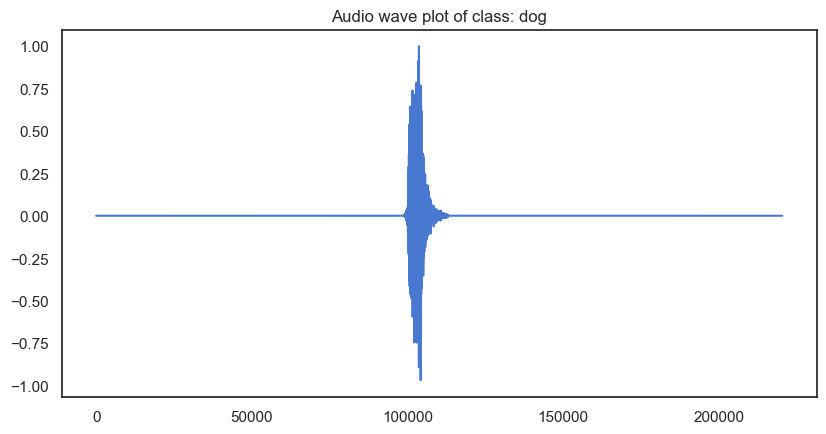

In [ ]:
batch_size = 30

dataset, label = create_dataset_lite(df_ESC10,
                                     batch_size = batch_size,
                                     ndim = 2)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 1)

In [ ]:
def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = INPUT_DIM,
                 n_filters = 1,
                 n_units = 8,
                 kernel_size = 100,
                 activation = 'tanh',
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0,
                 compile = True):
    strides = int(kernel_size/2)
    model = tf.keras.Sequential([
        #reduce the dimensionality of the input with a 1DConvolution
        tf.keras.layers.Conv1D(filters=n_filters, kernel_size = kernel_size, strides=strides, activation=activation, input_shape=INPUT_DIM),
        #with more than 1 filters I'll have prpoblems with the channel dimension not accepted by Recurrent layers
        #apply a SimpleRNN layer
        tf.keras.layers.GRU(units=n_units, activation=activation),
        tf.keras.layers.Dense(n_labels, activation='softmax')
    ])
    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()

    print(f'filters {n_filters}, kernel size {kernel_size}, units of GRU {n_units}, lr {learning_rate}, activation {activation}, strides {strides}')
    print(f' Trainable parameters: {model.count_params()}')
    return model



In [ ]:
epochs = 50
patience = 10

# the grid search is too big to be implemented over all parameter space:

# Grid search for the 1DConv layer
print('FIRST GRID SEARCH')
params = {'n_filters':[1],'kernel_size':[64,128,256], 'learning_rate':[1e-3, 1e-4]}
#params = {'n_filters':[1],'kernel_size':[64], 'learning_rate':[1e-3, 1e-4]}
K_fold = 4
model_cv, result, best_params = K_fold_training(dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 1, K=K_fold)


FIRST GRID SEARCH


2023-08-26 02:35:04.164647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]
2023-08-26 02:35:04.164836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]


(400, 220500, 1)
(400, 10)
Fitting 4 folds for each of 6 candidates, totalling 24 fits
filters 1, kernel size 64, units of GRU 8, lr 0.001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 02:35:05.704080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 02:35:05.704649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 02:35:05.705282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 23s 2s/step - loss: 2.3005 - accuracy: 0.0467
Epoch 2/50
10/10 [==============================] - 23s 2s/step - loss: 2.2993 - accuracy: 0.0667
Epoch 3/50
10/10 [==============================] - 22s 2s/step - loss: 2.2988 - accuracy: 0.0733
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 2.2979 - accuracy: 0.0733
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 2.2976 - accuracy: 0.0800
Epoch 6/50
10/10 [==============================] - 23s 2s/step - loss: 2.2965 - accuracy: 0.0867
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 2.2958 - accuracy: 0.0967
Epoch 8/50
10/10 [==============================] - 22s 2s/step - loss: 2.2949 - accuracy: 0.1000
Epoch 9/50
10/10 [==============================] - 22s 2s/step - loss: 2.2941 - accuracy: 0.0767
Epoch 10/50
10/10 [==============================] - 23s 2s/step - loss: 2.2931 - accuracy: 0.0733
Epoch 11/50
10/10 [===========

2023-08-26 02:42:03.734859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 02:42:03.735596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 02:42:03.736061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 132ms/step
accuracy on test for this fold is 0.05
filters 1, kernel size 64, units of GRU 8, lr 0.001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 02:42:04.699903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 02:42:04.700384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 02:42:04.701088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 26s 2s/step - loss: 2.3033 - accuracy: 0.0767
Epoch 2/50
10/10 [==============================] - 24s 2s/step - loss: 2.3022 - accuracy: 0.0733
Epoch 3/50
10/10 [==============================] - 23s 2s/step - loss: 2.3016 - accuracy: 0.1567
Epoch 4/50
10/10 [==============================] - 23s 2s/step - loss: 2.3011 - accuracy: 0.1400
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 2.3006 - accuracy: 0.1400
Epoch 6/50
10/10 [==============================] - 24s 2s/step - loss: 2.3000 - accuracy: 0.1433
Epoch 7/50
10/10 [==============================] - 25s 3s/step - loss: 2.2995 - accuracy: 0.1433
Epoch 8/50
10/10 [==============================] - 27s 3s/step - loss: 2.2988 - accuracy: 0.1433
Epoch 9/50
10/10 [==============================] - 28s 3s/step - loss: 2.2984 - accuracy: 0.1400
Epoch 10/50
10/10 [==============================] - 29s 3s/step - loss: 2.2975 - accuracy: 0.1400
Epoch 11/50
10/10 [===========

2023-08-26 02:47:44.556927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 02:47:44.557897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 02:47:44.558421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 154ms/step
accuracy on test for this fold is 0.02
filters 1, kernel size 64, units of GRU 8, lr 0.001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 02:47:45.709782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 02:47:45.710528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 02:47:45.711012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 29s 3s/step - loss: 2.3031 - accuracy: 0.0733
Epoch 2/50
10/10 [==============================] - 31s 3s/step - loss: 2.3025 - accuracy: 0.0733
Epoch 3/50
10/10 [==============================] - 32s 3s/step - loss: 2.3024 - accuracy: 0.1267
Epoch 4/50
10/10 [==============================] - 32s 3s/step - loss: 2.3021 - accuracy: 0.1333
Epoch 5/50
10/10 [==============================] - 30s 3s/step - loss: 2.3020 - accuracy: 0.1400
Epoch 6/50
10/10 [==============================] - 30s 3s/step - loss: 2.3018 - accuracy: 0.1300
Epoch 7/50
10/10 [==============================] - 30s 3s/step - loss: 2.3015 - accuracy: 0.1133
Epoch 8/50
10/10 [==============================] - 29s 3s/step - loss: 2.3014 - accuracy: 0.1100
Epoch 9/50
10/10 [==============================] - 29s 3s/step - loss: 2.3012 - accuracy: 0.1100
Epoch 10/50
10/10 [==============================] - 36s 4s/step - loss: 2.3008 - accuracy: 0.1200
Epoch 11/50
10/10 [===========

2023-08-26 03:11:02.379368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:11:02.380336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:11:02.380850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 123ms/step
accuracy on test for this fold is 0.17
filters 1, kernel size 64, units of GRU 8, lr 0.001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 03:11:04.061644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:11:04.062452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:11:04.062852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 26s 3s/step - loss: 2.3026 - accuracy: 0.1033
Epoch 2/50
10/10 [==============================] - 28s 3s/step - loss: 2.3017 - accuracy: 0.1100
Epoch 3/50
10/10 [==============================] - 28s 3s/step - loss: 2.3014 - accuracy: 0.1100
Epoch 4/50
10/10 [==============================] - 27s 3s/step - loss: 2.3009 - accuracy: 0.1000
Epoch 5/50
10/10 [==============================] - 27s 3s/step - loss: 2.3007 - accuracy: 0.1000
Epoch 6/50
10/10 [==============================] - 37s 4s/step - loss: 2.3004 - accuracy: 0.1000
Epoch 7/50
10/10 [==============================] - 28s 3s/step - loss: 2.2999 - accuracy: 0.0967
Epoch 8/50
10/10 [==============================] - 28s 3s/step - loss: 2.2996 - accuracy: 0.1033
Epoch 9/50
10/10 [==============================] - 25s 3s/step - loss: 2.2992 - accuracy: 0.1167
Epoch 10/50
10/10 [==============================] - 28s 3s/step - loss: 2.2988 - accuracy: 0.1133
Epoch 11/50
10/10 [===========

2023-08-26 03:32:25.783580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:32:25.784354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:32:25.784879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 127ms/step
accuracy on test for this fold is 0.18
filters 1, kernel size 64, units of GRU 8, lr 0.0001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 03:32:27.306661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:32:27.307094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:32:27.307491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 23s 2s/step - loss: 2.3015 - accuracy: 0.0600
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 2.3014 - accuracy: 0.0667
Epoch 3/50
10/10 [==============================] - 22s 2s/step - loss: 2.3013 - accuracy: 0.0733
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 2.3013 - accuracy: 0.0967
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 2.3012 - accuracy: 0.0933
Epoch 6/50
10/10 [==============================] - 26s 3s/step - loss: 2.3012 - accuracy: 0.1000
Epoch 7/50
10/10 [==============================] - 28s 3s/step - loss: 2.3011 - accuracy: 0.0933
Epoch 8/50
10/10 [==============================] - 23s 2s/step - loss: 2.3011 - accuracy: 0.0933
Epoch 9/50
10/10 [==============================] - 23s 2s/step - loss: 2.3010 - accuracy: 0.0767
Epoch 10/50
10/10 [==============================] - 24s 2s/step - loss: 2.3010 - accuracy: 0.0800
Epoch 11/50
10/10 [===========

2023-08-26 03:38:37.848238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:38:37.848739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:38:37.849190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 122ms/step
accuracy on test for this fold is 0.09
filters 1, kernel size 64, units of GRU 8, lr 0.0001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 03:38:38.677780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:38:38.678225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:38:38.678905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 23s 2s/step - loss: 2.3057 - accuracy: 0.0800
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 2.3055 - accuracy: 0.1100
Epoch 3/50
10/10 [==============================] - 22s 2s/step - loss: 2.3053 - accuracy: 0.1133
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 2.3052 - accuracy: 0.1100
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 2.3051 - accuracy: 0.1133
Epoch 6/50
10/10 [==============================] - 22s 2s/step - loss: 2.3049 - accuracy: 0.1100
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 2.3048 - accuracy: 0.1067
Epoch 8/50
10/10 [==============================] - 22s 2s/step - loss: 2.3046 - accuracy: 0.1067
Epoch 9/50
10/10 [==============================] - 22s 2s/step - loss: 2.3044 - accuracy: 0.1167
Epoch 10/50
10/10 [==============================] - 22s 2s/step - loss: 2.3043 - accuracy: 0.1133
Epoch 11/50
10/10 [===========

2023-08-26 03:45:51.942675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:45:51.943634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:45:51.944226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 131ms/step
accuracy on test for this fold is 0.09
filters 1, kernel size 64, units of GRU 8, lr 0.0001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 03:45:52.914754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:45:52.915626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:45:52.916066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 25s 2s/step - loss: 2.3016 - accuracy: 0.0567
Epoch 2/50
10/10 [==============================] - 25s 3s/step - loss: 2.3015 - accuracy: 0.0900
Epoch 3/50
10/10 [==============================] - 25s 3s/step - loss: 2.3015 - accuracy: 0.1400
Epoch 4/50
10/10 [==============================] - 24s 2s/step - loss: 2.3014 - accuracy: 0.0967
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 2.3014 - accuracy: 0.1300
Epoch 6/50
10/10 [==============================] - 22s 2s/step - loss: 2.3014 - accuracy: 0.1333
Epoch 7/50
10/10 [==============================] - 23s 2s/step - loss: 2.3013 - accuracy: 0.1267
Epoch 8/50
10/10 [==============================] - 22s 2s/step - loss: 2.3013 - accuracy: 0.1233
Epoch 9/50
10/10 [==============================] - 22s 2s/step - loss: 2.3013 - accuracy: 0.1233
Epoch 10/50
10/10 [==============================] - 23s 2s/step - loss: 2.3012 - accuracy: 0.1300
Epoch 11/50
10/10 [===========

2023-08-26 03:50:55.975535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:50:55.976123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:50:55.977081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 133ms/step
accuracy on test for this fold is 0.06
filters 1, kernel size 64, units of GRU 8, lr 0.0001, activation tanh, strides 32
 Trainable parameters: 419
Epoch 1/50


2023-08-26 03:50:56.960121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:50:56.961117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:50:56.961627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 24s 2s/step - loss: 2.3030 - accuracy: 0.0433
Epoch 2/50
10/10 [==============================] - 24s 2s/step - loss: 2.3030 - accuracy: 0.0267
Epoch 3/50
10/10 [==============================] - 24s 2s/step - loss: 2.3030 - accuracy: 0.0167
Epoch 4/50
10/10 [==============================] - 24s 2s/step - loss: 2.3029 - accuracy: 0.0333
Epoch 5/50
10/10 [==============================] - 24s 2s/step - loss: 2.3029 - accuracy: 0.0400
Epoch 6/50
10/10 [==============================] - 24s 2s/step - loss: 2.3029 - accuracy: 0.0400
Epoch 7/50
10/10 [==============================] - 25s 2s/step - loss: 2.3028 - accuracy: 0.0367
Epoch 8/50
10/10 [==============================] - 25s 3s/step - loss: 2.3028 - accuracy: 0.0367
Epoch 9/50
10/10 [==============================] - 25s 2s/step - loss: 2.3028 - accuracy: 0.0367
Epoch 10/50
10/10 [==============================] - 24s 2s/step - loss: 2.3028 - accuracy: 0.0267
Epoch 11/50
10/10 [===========

2023-08-26 03:55:23.754353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:55:23.754851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:55:23.755484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 127ms/step
accuracy on test for this fold is 0.01
filters 1, kernel size 128, units of GRU 8, lr 0.001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 03:55:24.622181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:55:24.622653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:55:24.623257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 9s 832ms/step - loss: 2.3044 - accuracy: 0.1000
Epoch 2/50
10/10 [==============================] - 8s 807ms/step - loss: 2.3026 - accuracy: 0.1567
Epoch 3/50
10/10 [==============================] - 8s 799ms/step - loss: 2.3018 - accuracy: 0.1067
Epoch 4/50
10/10 [==============================] - 8s 799ms/step - loss: 2.3011 - accuracy: 0.1200
Epoch 5/50
10/10 [==============================] - 8s 805ms/step - loss: 2.3004 - accuracy: 0.1200
Epoch 6/50
10/10 [==============================] - 8s 839ms/step - loss: 2.2997 - accuracy: 0.1200
Epoch 7/50
10/10 [==============================] - 9s 856ms/step - loss: 2.2990 - accuracy: 0.1300
Epoch 8/50
10/10 [==============================] - 8s 783ms/step - loss: 2.2985 - accuracy: 0.1267
Epoch 9/50
10/10 [==============================] - 8s 777ms/step - loss: 2.2980 - accuracy: 0.1333
Epoch 10/50
10/10 [==============================] - 8s 825ms/step - loss: 2.2974 - accuracy: 0.1433
Epoch 11/5

2023-08-26 03:57:02.997591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:57:02.998714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:57:02.999266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 68ms/step
accuracy on test for this fold is 0.1
filters 1, kernel size 128, units of GRU 8, lr 0.001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 03:57:03.655478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 03:57:03.655972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 03:57:03.656416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 10s 790ms/step - loss: 2.3034 - accuracy: 0.0867
Epoch 2/50
10/10 [==============================] - 8s 780ms/step - loss: 2.3007 - accuracy: 0.1500
Epoch 3/50
10/10 [==============================] - 8s 783ms/step - loss: 2.2993 - accuracy: 0.1500
Epoch 4/50
10/10 [==============================] - 8s 772ms/step - loss: 2.2975 - accuracy: 0.1733
Epoch 5/50
10/10 [==============================] - 8s 777ms/step - loss: 2.2964 - accuracy: 0.1767
Epoch 6/50
10/10 [==============================] - 8s 762ms/step - loss: 2.2948 - accuracy: 0.1767
Epoch 7/50
10/10 [==============================] - 8s 765ms/step - loss: 2.2936 - accuracy: 0.1767
Epoch 8/50
10/10 [==============================] - 8s 760ms/step - loss: 2.2918 - accuracy: 0.1767
Epoch 9/50
10/10 [==============================] - 8s 768ms/step - loss: 2.2902 - accuracy: 0.1733
Epoch 10/50
10/10 [==============================] - 8s 759ms/step - loss: 2.2887 - accuracy: 0.1733
Epoch 11/

2023-08-26 04:01:57.303594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:01:57.304226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:01:57.304891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 69ms/step
accuracy on test for this fold is 0.11
filters 1, kernel size 128, units of GRU 8, lr 0.001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 04:01:57.994520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:01:57.994953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:01:57.995576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 9s 781ms/step - loss: 2.3031 - accuracy: 0.0667
Epoch 2/50
10/10 [==============================] - 8s 781ms/step - loss: 2.3021 - accuracy: 0.1100
Epoch 3/50
10/10 [==============================] - 8s 797ms/step - loss: 2.3020 - accuracy: 0.1400
Epoch 4/50
10/10 [==============================] - 8s 791ms/step - loss: 2.3014 - accuracy: 0.1467
Epoch 5/50
10/10 [==============================] - 8s 795ms/step - loss: 2.3011 - accuracy: 0.1467
Epoch 6/50
10/10 [==============================] - 8s 782ms/step - loss: 2.3007 - accuracy: 0.1433
Epoch 7/50
10/10 [==============================] - 8s 777ms/step - loss: 2.3002 - accuracy: 0.1333
Epoch 8/50
10/10 [==============================] - 8s 783ms/step - loss: 2.2999 - accuracy: 0.1367
Epoch 9/50
10/10 [==============================] - 8s 773ms/step - loss: 2.2994 - accuracy: 0.1400
Epoch 10/50
10/10 [==============================] - 8s 775ms/step - loss: 2.2989 - accuracy: 0.1133
Epoch 11/5

2023-08-26 04:08:20.367566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:08:20.368058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:08:20.368681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 65ms/step
accuracy on test for this fold is 0.19
filters 1, kernel size 128, units of GRU 8, lr 0.001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 04:08:21.055155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:08:21.055615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:08:21.056045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 9s 762ms/step - loss: 2.3044 - accuracy: 0.0500
Epoch 2/50
10/10 [==============================] - 8s 751ms/step - loss: 2.3035 - accuracy: 0.0633
Epoch 3/50
10/10 [==============================] - 8s 752ms/step - loss: 2.3031 - accuracy: 0.0967
Epoch 4/50
10/10 [==============================] - 8s 753ms/step - loss: 2.3024 - accuracy: 0.1100
Epoch 5/50
10/10 [==============================] - 8s 752ms/step - loss: 2.3022 - accuracy: 0.1167
Epoch 6/50
10/10 [==============================] - 8s 752ms/step - loss: 2.3018 - accuracy: 0.1233
Epoch 7/50
10/10 [==============================] - 8s 751ms/step - loss: 2.3013 - accuracy: 0.1267
Epoch 8/50
10/10 [==============================] - 8s 751ms/step - loss: 2.3011 - accuracy: 0.1300
Epoch 9/50
10/10 [==============================] - 8s 752ms/step - loss: 2.3007 - accuracy: 0.1333
Epoch 10/50
10/10 [==============================] - 8s 750ms/step - loss: 2.3006 - accuracy: 0.1267
Epoch 11/5

2023-08-26 04:14:37.956946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:14:37.957427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:14:37.957946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 68ms/step
accuracy on test for this fold is 0.09
filters 1, kernel size 128, units of GRU 8, lr 0.0001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 04:14:38.588039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:14:38.588492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:14:38.589088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 9s 763ms/step - loss: 2.3019 - accuracy: 0.0600
Epoch 2/50
10/10 [==============================] - 8s 760ms/step - loss: 2.3018 - accuracy: 0.0700
Epoch 3/50
10/10 [==============================] - 8s 756ms/step - loss: 2.3018 - accuracy: 0.0933
Epoch 4/50
10/10 [==============================] - 8s 758ms/step - loss: 2.3017 - accuracy: 0.0967
Epoch 5/50
10/10 [==============================] - 7s 744ms/step - loss: 2.3017 - accuracy: 0.0967
Epoch 6/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3016 - accuracy: 0.1033
Epoch 7/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3015 - accuracy: 0.1100
Epoch 8/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3014 - accuracy: 0.1067
Epoch 9/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3014 - accuracy: 0.1033
Epoch 10/50
10/10 [==============================] - 7s 740ms/step - loss: 2.3013 - accuracy: 0.1000
Epoch 11/5

2023-08-26 04:16:46.436785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:16:46.437278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:16:46.437747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 64ms/step
accuracy on test for this fold is 0.06
filters 1, kernel size 128, units of GRU 8, lr 0.0001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 04:16:47.154544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:16:47.155251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:16:47.155918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 741ms/step - loss: 2.3044 - accuracy: 0.0600
Epoch 2/50
10/10 [==============================] - 7s 744ms/step - loss: 2.3041 - accuracy: 0.0833
Epoch 3/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3040 - accuracy: 0.1367
Epoch 4/50
10/10 [==============================] - 7s 744ms/step - loss: 2.3038 - accuracy: 0.1467
Epoch 5/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3037 - accuracy: 0.1533
Epoch 6/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3035 - accuracy: 0.1533
Epoch 7/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3033 - accuracy: 0.1533
Epoch 8/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3032 - accuracy: 0.1567
Epoch 9/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3030 - accuracy: 0.1567
Epoch 10/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3029 - accuracy: 0.1567
Epoch 11/5

2023-08-26 04:19:23.992194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:19:23.993072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:19:23.993849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 64ms/step
accuracy on test for this fold is 0.03
filters 1, kernel size 128, units of GRU 8, lr 0.0001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 04:19:24.699398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:19:24.699867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:19:24.700314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 745ms/step - loss: 2.3022 - accuracy: 0.0667
Epoch 2/50
10/10 [==============================] - 7s 740ms/step - loss: 2.3021 - accuracy: 0.0833
Epoch 3/50
10/10 [==============================] - 7s 739ms/step - loss: 2.3021 - accuracy: 0.1400
Epoch 4/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3020 - accuracy: 0.1500
Epoch 5/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3020 - accuracy: 0.1500
Epoch 6/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3020 - accuracy: 0.1533
Epoch 7/50
10/10 [==============================] - 7s 743ms/step - loss: 2.3020 - accuracy: 0.1500
Epoch 8/50
10/10 [==============================] - 7s 740ms/step - loss: 2.3019 - accuracy: 0.1500
Epoch 9/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3019 - accuracy: 0.1433
Epoch 10/50
10/10 [==============================] - 7s 740ms/step - loss: 2.3019 - accuracy: 0.1267
Epoch 11/5

2023-08-26 04:21:24.232682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:21:24.233164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:21:24.233915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 64ms/step
accuracy on test for this fold is 0.12
filters 1, kernel size 128, units of GRU 8, lr 0.0001, activation tanh, strides 64
 Trainable parameters: 483
Epoch 1/50


2023-08-26 04:21:24.903181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:21:24.903954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:21:24.904708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 9s 747ms/step - loss: 2.3048 - accuracy: 0.1267
Epoch 2/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3047 - accuracy: 0.1867
Epoch 3/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3047 - accuracy: 0.1400
Epoch 4/50
10/10 [==============================] - 7s 745ms/step - loss: 2.3046 - accuracy: 0.1100
Epoch 5/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3045 - accuracy: 0.1100
Epoch 6/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3044 - accuracy: 0.1100
Epoch 7/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3043 - accuracy: 0.1067
Epoch 8/50
10/10 [==============================] - 7s 742ms/step - loss: 2.3043 - accuracy: 0.1067
Epoch 9/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3042 - accuracy: 0.1100
Epoch 10/50
10/10 [==============================] - 7s 741ms/step - loss: 2.3041 - accuracy: 0.1100
Epoch 11/5

2023-08-26 04:22:55.584260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:22:55.584713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:22:55.585146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 64ms/step
accuracy on test for this fold is 0.08
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:22:56.056306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:22:56.056723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:22:56.057130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 304ms/step - loss: 2.3035 - accuracy: 0.0933
Epoch 2/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3016 - accuracy: 0.1567
Epoch 3/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3008 - accuracy: 0.1600
Epoch 4/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3000 - accuracy: 0.1200
Epoch 5/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2995 - accuracy: 0.1433
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2986 - accuracy: 0.1833
Epoch 7/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2974 - accuracy: 0.1633
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2961 - accuracy: 0.1200
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2948 - accuracy: 0.1233
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2931 - accuracy: 0.1233
Epoch 11/5

2023-08-26 04:23:45.527225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:23:45.527832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:23:45.528392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 35ms/step
accuracy on test for this fold is 0.15
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:23:45.896057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:23:45.896597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:23:45.897050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 304ms/step - loss: 2.3018 - accuracy: 0.0533
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2998 - accuracy: 0.1100
Epoch 3/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2985 - accuracy: 0.1567
Epoch 4/50
10/10 [==============================] - 3s 307ms/step - loss: 2.2973 - accuracy: 0.1533
Epoch 5/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2964 - accuracy: 0.1500
Epoch 6/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2949 - accuracy: 0.1600
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2937 - accuracy: 0.1567
Epoch 8/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2919 - accuracy: 0.1633
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2904 - accuracy: 0.1667
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2889 - accuracy: 0.1767
Epoch 11/5

2023-08-26 04:26:18.608628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:26:18.609085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:26:18.609512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.12
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:26:19.010944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:26:19.011368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:26:19.011898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 306ms/step - loss: 2.3031 - accuracy: 0.0267
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3024 - accuracy: 0.0700
Epoch 3/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3021 - accuracy: 0.1100
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3017 - accuracy: 0.1167
Epoch 5/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3014 - accuracy: 0.1400
Epoch 6/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3010 - accuracy: 0.1433
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3003 - accuracy: 0.1467
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2997 - accuracy: 0.1533
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2989 - accuracy: 0.1567
Epoch 10/50
10/10 [==============================] - 3s 302ms/step - loss: 2.2978 - accuracy: 0.1600
Epoch 11/5

2023-08-26 04:28:51.681345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:28:51.681802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:28:51.682229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.19
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:28:52.120119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:28:52.120541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:28:52.120939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 305ms/step - loss: 2.3022 - accuracy: 0.0767
Epoch 2/50
10/10 [==============================] - 3s 305ms/step - loss: 2.3007 - accuracy: 0.1267
Epoch 3/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2997 - accuracy: 0.1667
Epoch 4/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2986 - accuracy: 0.0933
Epoch 5/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2974 - accuracy: 0.1033
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2964 - accuracy: 0.1033
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2947 - accuracy: 0.1700
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2929 - accuracy: 0.1700
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2908 - accuracy: 0.1700
Epoch 10/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2886 - accuracy: 0.1667
Epoch 11/5

2023-08-26 04:29:56.933077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:29:56.933537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:29:56.933957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 35ms/step
accuracy on test for this fold is 0.13
filters 1, kernel size 256, units of GRU 8, lr 0.0001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:29:57.383611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:29:57.384091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:29:57.384701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 306ms/step - loss: 2.3019 - accuracy: 0.0567
Epoch 2/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3018 - accuracy: 0.0533
Epoch 3/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3017 - accuracy: 0.0600
Epoch 4/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3016 - accuracy: 0.0633
Epoch 5/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3016 - accuracy: 0.0633
Epoch 6/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3014 - accuracy: 0.0633
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3014 - accuracy: 0.0633
Epoch 8/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3013 - accuracy: 0.0667
Epoch 9/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3012 - accuracy: 0.0667
Epoch 10/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3011 - accuracy: 0.0667
Epoch 11/5

2023-08-26 04:31:31.993221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:31:31.993697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:31:31.994151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.03
filters 1, kernel size 256, units of GRU 8, lr 0.0001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:31:32.628561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:31:32.630705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:31:32.631402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 307ms/step - loss: 2.3036 - accuracy: 0.0367
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3034 - accuracy: 0.0467
Epoch 3/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3033 - accuracy: 0.1233
Epoch 4/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3031 - accuracy: 0.1333
Epoch 5/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3030 - accuracy: 0.1300
Epoch 6/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3029 - accuracy: 0.1433
Epoch 7/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3027 - accuracy: 0.1367
Epoch 8/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3026 - accuracy: 0.1367
Epoch 9/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3025 - accuracy: 0.1367
Epoch 10/50
10/10 [==============================] - 3s 302ms/step - loss: 2.3023 - accuracy: 0.1367
Epoch 11/5

2023-08-26 04:32:22.765757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:32:22.766245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:32:22.766891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 34ms/step
accuracy on test for this fold is 0.02
filters 1, kernel size 256, units of GRU 8, lr 0.0001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:32:23.178962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:32:23.179376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:32:23.179777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 304ms/step - loss: 2.3025 - accuracy: 0.0567
Epoch 2/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3025 - accuracy: 0.0600
Epoch 3/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3024 - accuracy: 0.1400
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3024 - accuracy: 0.1600
Epoch 5/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3024 - accuracy: 0.1600
Epoch 6/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3023 - accuracy: 0.1567
Epoch 7/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3023 - accuracy: 0.1533
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3022 - accuracy: 0.1500
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3022 - accuracy: 0.1500
Epoch 10/50
10/10 [==============================] - 3s 301ms/step - loss: 2.3022 - accuracy: 0.1500
Epoch 11/5

2023-08-26 04:33:06.537518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:33:06.537970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:33:06.538397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.13
filters 1, kernel size 256, units of GRU 8, lr 0.0001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:33:06.890154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:33:06.890676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:33:06.891179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 304ms/step - loss: 2.3031 - accuracy: 0.0500
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3030 - accuracy: 0.0700
Epoch 3/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3029 - accuracy: 0.1167
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3028 - accuracy: 0.0233
Epoch 5/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3028 - accuracy: 0.0167
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.3027 - accuracy: 0.0267
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3027 - accuracy: 0.0300
Epoch 8/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3026 - accuracy: 0.0267
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3025 - accuracy: 0.0333
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3025 - accuracy: 0.0367
Epoch 11/5

2023-08-26 04:33:47.299312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:33:47.299770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:33:47.300194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.04
The best parameters are {'kernel_size': 256, 'learning_rate': 0.001, 'n_filters': 1}
The accuracy score are


mean_accuracy
{'kernel_size': 256, 'learning_rate': 0.001, 'n...         0.1475
{'kernel_size': 128, 'learning_rate': 0.001, 'n...         0.1225
{'kernel_size': 64, 'learning_rate': 0.001, 'n_...         0.1050
{'kernel_size': 128, 'learning_rate': 0.0001, '...         0.0725
{'kernel_size': 64, 'learning_rate': 0.0001, 'n...         0.0625
{'kernel_size': 256, 'learning_rate': 0.0001, '...         0.0550

In [ ]:
#best_params = {'kernel_size': 128, 'learning_rate': 0.001, 'n_filters': 1} #output of first grid search
#grid search for GRU layer
print('SECOND GRID SEARCH')
params = {'n_units':[8,32,128],'activation':['tanh'], 'learning_rate':[1e-3, 1e-2], 'n_filters':[best_params['n_filters']], 'kernel_size':[best_params['kernel_size']]}
#params = {'n_units':[8],'activation':['tanh'], 'learning_rate':[1e-3, 1e-2], 'n_filters':[best_params['n_filters']], 'kernel_size':[best_params['kernel_size']]}

K_fold = 4
model_cv, result, best_params = K_fold_training(dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 1, K=K_fold)


SECOND GRID SEARCH


(400, 220500, 1)
(400, 10)
Fitting 4 folds for each of 6 candidates, totalling 24 fits
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:33:48.008752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:33:48.009194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:33:48.009618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 305ms/step - loss: 2.3036 - accuracy: 0.0800
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3020 - accuracy: 0.0867
Epoch 3/50
10/10 [==============================] - 3s 306ms/step - loss: 2.3011 - accuracy: 0.1133
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3004 - accuracy: 0.1367
Epoch 5/50
10/10 [==============================] - 3s 305ms/step - loss: 2.3000 - accuracy: 0.1267
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2993 - accuracy: 0.1300
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2987 - accuracy: 0.1300
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2980 - accuracy: 0.1233
Epoch 9/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2975 - accuracy: 0.1200
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2969 - accuracy: 0.1200
Epoch 11/5

2023-08-26 04:34:31.551508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:34:31.551953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:34:31.552390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.11
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:34:32.084478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:34:32.084917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:34:32.085338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 306ms/step - loss: 2.3044 - accuracy: 0.0633
Epoch 2/50
10/10 [==============================] - 3s 305ms/step - loss: 2.3012 - accuracy: 0.0833
Epoch 3/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2998 - accuracy: 0.1133
Epoch 4/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2985 - accuracy: 0.1800
Epoch 5/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2971 - accuracy: 0.1700
Epoch 6/50
10/10 [==============================] - 3s 307ms/step - loss: 2.2956 - accuracy: 0.1700
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2939 - accuracy: 0.1800
Epoch 8/50
10/10 [==============================] - 3s 306ms/step - loss: 2.2917 - accuracy: 0.1800
Epoch 9/50
10/10 [==============================] - 3s 306ms/step - loss: 2.2895 - accuracy: 0.1800
Epoch 10/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2870 - accuracy: 0.1800
Epoch 11/5

2023-08-26 04:35:15.792557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:35:15.793004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:35:15.793680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 35ms/step
accuracy on test for this fold is 0.03
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:35:16.266670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:35:16.267112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:35:16.267743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 305ms/step - loss: 2.3039 - accuracy: 0.1500
Epoch 2/50
10/10 [==============================] - 3s 305ms/step - loss: 2.3017 - accuracy: 0.1567
Epoch 3/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3007 - accuracy: 0.1500
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2999 - accuracy: 0.1700
Epoch 5/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2989 - accuracy: 0.1533
Epoch 6/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2978 - accuracy: 0.1500
Epoch 7/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2958 - accuracy: 0.1500
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2942 - accuracy: 0.1300
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2920 - accuracy: 0.1533
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2896 - accuracy: 0.1567
Epoch 11/5

2023-08-26 04:37:48.699600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:37:48.700070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:37:48.700693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 35ms/step
accuracy on test for this fold is 0.19
filters 1, kernel size 256, units of GRU 8, lr 0.001, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 04:37:49.268232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:37:49.268721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:37:49.269572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 306ms/step - loss: 2.3034 - accuracy: 0.0800
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.3018 - accuracy: 0.1533
Epoch 3/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3012 - accuracy: 0.1400
Epoch 4/50
10/10 [==============================] - 3s 303ms/step - loss: 2.3001 - accuracy: 0.0900
Epoch 5/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2992 - accuracy: 0.1200
Epoch 6/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2982 - accuracy: 0.1267
Epoch 7/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2968 - accuracy: 0.1267
Epoch 8/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2955 - accuracy: 0.1567
Epoch 9/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2939 - accuracy: 0.1767
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 2.2920 - accuracy: 0.1933
Epoch 11/5

2023-08-26 04:39:24.171390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:39:24.171882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:39:24.172486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 35ms/step
accuracy on test for this fold is 0.06
filters 1, kernel size 256, units of GRU 32, lr 0.001, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 04:39:24.802316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:39:24.802916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:39:24.803412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 5s 333ms/step - loss: 2.3040 - accuracy: 0.0567
Epoch 2/50
10/10 [==============================] - 3s 332ms/step - loss: 2.3009 - accuracy: 0.0967
Epoch 3/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2997 - accuracy: 0.1267
Epoch 4/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2980 - accuracy: 0.1433
Epoch 5/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2968 - accuracy: 0.1433
Epoch 6/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2943 - accuracy: 0.1467
Epoch 7/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2916 - accuracy: 0.1467
Epoch 8/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2880 - accuracy: 0.1467
Epoch 9/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2836 - accuracy: 0.1167
Epoch 10/50
10/10 [==============================] - 3s 331ms/step - loss: 2.2775 - accuracy: 0.1133
Epoch 11/5

2023-08-26 04:41:35.807246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:41:35.807701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:41:35.808126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 41ms/step
accuracy on test for this fold is 0.17
filters 1, kernel size 256, units of GRU 32, lr 0.001, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 04:41:36.190716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:41:36.191136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:41:36.191551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 334ms/step - loss: 2.3032 - accuracy: 0.0800
Epoch 2/50
10/10 [==============================] - 3s 334ms/step - loss: 2.3006 - accuracy: 0.1067
Epoch 3/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2988 - accuracy: 0.1267
Epoch 4/50
10/10 [==============================] - 3s 335ms/step - loss: 2.2966 - accuracy: 0.1433
Epoch 5/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2948 - accuracy: 0.1500
Epoch 6/50
10/10 [==============================] - 3s 335ms/step - loss: 2.2909 - accuracy: 0.1500
Epoch 7/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2867 - accuracy: 0.1467
Epoch 8/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2802 - accuracy: 0.1567
Epoch 9/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2725 - accuracy: 0.1633
Epoch 10/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2627 - accuracy: 0.1667
Epoch 11/5

2023-08-26 04:44:24.254825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:44:24.255287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:44:24.255720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 42ms/step
accuracy on test for this fold is 0.14
filters 1, kernel size 256, units of GRU 32, lr 0.001, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 04:44:24.636429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:44:24.636934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:44:24.637419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 335ms/step - loss: 2.3037 - accuracy: 0.0567
Epoch 2/50
10/10 [==============================] - 3s 335ms/step - loss: 2.3026 - accuracy: 0.1033
Epoch 3/50
10/10 [==============================] - 3s 334ms/step - loss: 2.3020 - accuracy: 0.1067
Epoch 4/50
10/10 [==============================] - 3s 334ms/step - loss: 2.3012 - accuracy: 0.1133
Epoch 5/50
10/10 [==============================] - 3s 336ms/step - loss: 2.3003 - accuracy: 0.1300
Epoch 6/50
10/10 [==============================] - 3s 336ms/step - loss: 2.2990 - accuracy: 0.1300
Epoch 7/50
10/10 [==============================] - 3s 335ms/step - loss: 2.2968 - accuracy: 0.1533
Epoch 8/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2940 - accuracy: 0.1633
Epoch 9/50
10/10 [==============================] - 3s 335ms/step - loss: 2.2894 - accuracy: 0.1567
Epoch 10/50
10/10 [==============================] - 3s 335ms/step - loss: 2.2805 - accuracy: 0.1800
Epoch 11/5

2023-08-26 04:47:13.054703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:47:13.055252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:47:13.055978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 42ms/step
accuracy on test for this fold is 0.2
filters 1, kernel size 256, units of GRU 32, lr 0.001, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 04:47:13.477699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:47:13.478281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:47:13.478835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 334ms/step - loss: 2.3036 - accuracy: 0.1000
Epoch 2/50
10/10 [==============================] - 3s 333ms/step - loss: 2.3020 - accuracy: 0.1133
Epoch 3/50
10/10 [==============================] - 3s 333ms/step - loss: 2.3016 - accuracy: 0.0967
Epoch 4/50
10/10 [==============================] - 3s 334ms/step - loss: 2.3003 - accuracy: 0.1100
Epoch 5/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2991 - accuracy: 0.1233
Epoch 6/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2976 - accuracy: 0.1300
Epoch 7/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2949 - accuracy: 0.1267
Epoch 8/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2915 - accuracy: 0.1300
Epoch 9/50
10/10 [==============================] - 3s 334ms/step - loss: 2.2873 - accuracy: 0.1567
Epoch 10/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2814 - accuracy: 0.1567
Epoch 11/5

2023-08-26 04:50:01.304921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:50:01.305378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:50:01.305813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 42ms/step
accuracy on test for this fold is 0.23
filters 1, kernel size 256, units of GRU 128, lr 0.001, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 04:50:01.898427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:50:01.898891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:50:01.899311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 677ms/step - loss: 2.3044 - accuracy: 0.0800
Epoch 2/50
10/10 [==============================] - 7s 678ms/step - loss: 2.3009 - accuracy: 0.0967
Epoch 3/50
10/10 [==============================] - 7s 682ms/step - loss: 2.2997 - accuracy: 0.1233
Epoch 4/50
10/10 [==============================] - 7s 681ms/step - loss: 2.2967 - accuracy: 0.1267
Epoch 5/50
10/10 [==============================] - 7s 678ms/step - loss: 2.2940 - accuracy: 0.0967
Epoch 6/50
10/10 [==============================] - 7s 683ms/step - loss: 2.2856 - accuracy: 0.1233
Epoch 7/50
10/10 [==============================] - 7s 676ms/step - loss: 2.2730 - accuracy: 0.1100
Epoch 8/50
10/10 [==============================] - 7s 686ms/step - loss: 2.2364 - accuracy: 0.1067
Epoch 9/50
10/10 [==============================] - 7s 674ms/step - loss: 2.2227 - accuracy: 0.1500
Epoch 10/50
10/10 [==============================] - 7s 682ms/step - loss: 2.2137 - accuracy: 0.1533
Epoch 11/5

2023-08-26 04:55:42.028293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:55:42.028757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:55:42.029185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 126ms/step
accuracy on test for this fold is 0.2
filters 1, kernel size 256, units of GRU 128, lr 0.001, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 04:55:42.957141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 04:55:42.957598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 04:55:42.958024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 660ms/step - loss: 2.3046 - accuracy: 0.0767
Epoch 2/50
10/10 [==============================] - 7s 658ms/step - loss: 2.3010 - accuracy: 0.1100
Epoch 3/50
10/10 [==============================] - 7s 657ms/step - loss: 2.2989 - accuracy: 0.1333
Epoch 4/50
10/10 [==============================] - 7s 654ms/step - loss: 2.2963 - accuracy: 0.1267
Epoch 5/50
10/10 [==============================] - 7s 653ms/step - loss: 2.2940 - accuracy: 0.1333
Epoch 6/50
10/10 [==============================] - 7s 654ms/step - loss: 2.2870 - accuracy: 0.1500
Epoch 7/50
10/10 [==============================] - 7s 654ms/step - loss: 2.2766 - accuracy: 0.1667
Epoch 8/50
10/10 [==============================] - 7s 655ms/step - loss: 2.2568 - accuracy: 0.1833
Epoch 9/50
10/10 [==============================] - 7s 657ms/step - loss: 2.2219 - accuracy: 0.1900
Epoch 10/50
10/10 [==============================] - 7s 652ms/step - loss: 2.1985 - accuracy: 0.1967
Epoch 11/5

2023-08-26 05:00:56.724781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:00:56.725428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:00:56.725954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 121ms/step
accuracy on test for this fold is 0.05
filters 1, kernel size 256, units of GRU 128, lr 0.001, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 05:00:57.658707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:00:57.659147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:00:57.659568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 669ms/step - loss: 2.3046 - accuracy: 0.0933
Epoch 2/50
10/10 [==============================] - 7s 674ms/step - loss: 2.3012 - accuracy: 0.1300
Epoch 3/50
10/10 [==============================] - 7s 670ms/step - loss: 2.2983 - accuracy: 0.1600
Epoch 4/50
10/10 [==============================] - 7s 667ms/step - loss: 2.2937 - accuracy: 0.1733
Epoch 5/50
10/10 [==============================] - 7s 668ms/step - loss: 2.2861 - accuracy: 0.1767
Epoch 6/50
10/10 [==============================] - 7s 672ms/step - loss: 2.2700 - accuracy: 0.1833
Epoch 7/50
10/10 [==============================] - 7s 665ms/step - loss: 2.2451 - accuracy: 0.1833
Epoch 8/50
10/10 [==============================] - 7s 675ms/step - loss: 2.2283 - accuracy: 0.1900
Epoch 9/50
10/10 [==============================] - 7s 672ms/step - loss: 2.2108 - accuracy: 0.1967
Epoch 10/50
10/10 [==============================] - 7s 661ms/step - loss: 2.2051 - accuracy: 0.1933
Epoch 11/5

2023-08-26 05:06:36.133028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:06:36.133629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:06:36.134245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 122ms/step
accuracy on test for this fold is 0.14
filters 1, kernel size 256, units of GRU 128, lr 0.001, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 05:06:36.875783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:06:36.876202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:06:36.876721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 677ms/step - loss: 2.3038 - accuracy: 0.0933
Epoch 2/50
10/10 [==============================] - 7s 672ms/step - loss: 2.3002 - accuracy: 0.1500
Epoch 3/50
10/10 [==============================] - 7s 684ms/step - loss: 2.2979 - accuracy: 0.1500
Epoch 4/50
10/10 [==============================] - 7s 679ms/step - loss: 2.2926 - accuracy: 0.1200
Epoch 5/50
10/10 [==============================] - 7s 684ms/step - loss: 2.2857 - accuracy: 0.1200
Epoch 6/50
10/10 [==============================] - 7s 683ms/step - loss: 2.2720 - accuracy: 0.1200
Epoch 7/50
10/10 [==============================] - 7s 673ms/step - loss: 2.2655 - accuracy: 0.1400
Epoch 8/50
10/10 [==============================] - 7s 681ms/step - loss: 2.2587 - accuracy: 0.1333
Epoch 9/50
10/10 [==============================] - 7s 680ms/step - loss: 2.2361 - accuracy: 0.1267
Epoch 10/50
10/10 [==============================] - 7s 677ms/step - loss: 2.2446 - accuracy: 0.1367
Epoch 11/5

2023-08-26 05:07:59.538099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:07:59.538618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:07:59.539066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 122ms/step
accuracy on test for this fold is 0.09
filters 1, kernel size 256, units of GRU 8, lr 0.01, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 05:08:00.298966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:08:00.299383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:08:00.299797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 306ms/step - loss: 2.3072 - accuracy: 0.0700
Epoch 2/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2912 - accuracy: 0.1500
Epoch 3/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2726 - accuracy: 0.1533
Epoch 4/50
10/10 [==============================] - 3s 306ms/step - loss: 2.2304 - accuracy: 0.2133
Epoch 5/50
10/10 [==============================] - 3s 305ms/step - loss: 2.1532 - accuracy: 0.1600
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.0628 - accuracy: 0.1767
Epoch 7/50
10/10 [==============================] - 3s 305ms/step - loss: 2.0108 - accuracy: 0.1967
Epoch 8/50
10/10 [==============================] - 3s 305ms/step - loss: 1.9775 - accuracy: 0.2067
Epoch 9/50
10/10 [==============================] - 3s 306ms/step - loss: 1.9572 - accuracy: 0.2333
Epoch 10/50
10/10 [==============================] - 3s 304ms/step - loss: 1.9449 - accuracy: 0.2267
Epoch 11/5

2023-08-26 05:10:33.350984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:10:33.351436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:10:33.351872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 35ms/step
accuracy on test for this fold is 0.24
filters 1, kernel size 256, units of GRU 8, lr 0.01, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 05:10:33.799739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:10:33.800187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:10:33.800594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 305ms/step - loss: 2.3106 - accuracy: 0.0700
Epoch 2/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2862 - accuracy: 0.1567
Epoch 3/50
10/10 [==============================] - 3s 306ms/step - loss: 2.2605 - accuracy: 0.1767
Epoch 4/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2200 - accuracy: 0.1967
Epoch 5/50
10/10 [==============================] - 3s 305ms/step - loss: 2.1501 - accuracy: 0.2167
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.0504 - accuracy: 0.1867
Epoch 7/50
10/10 [==============================] - 3s 305ms/step - loss: 1.9537 - accuracy: 0.2200
Epoch 8/50
10/10 [==============================] - 3s 305ms/step - loss: 1.9194 - accuracy: 0.2267
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 1.8774 - accuracy: 0.2733
Epoch 10/50
10/10 [==============================] - 3s 302ms/step - loss: 1.8265 - accuracy: 0.2600
Epoch 11/5

2023-08-26 05:13:06.423003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:13:06.423477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:13:06.423915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.29
filters 1, kernel size 256, units of GRU 8, lr 0.01, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 05:13:06.826868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:13:06.827304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:13:06.827875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 305ms/step - loss: 2.3104 - accuracy: 0.0600
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2951 - accuracy: 0.1567
Epoch 3/50
10/10 [==============================] - 3s 305ms/step - loss: 2.2769 - accuracy: 0.1933
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2099 - accuracy: 0.2133
Epoch 5/50
10/10 [==============================] - 3s 305ms/step - loss: 2.0652 - accuracy: 0.2033
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 1.9817 - accuracy: 0.2133
Epoch 7/50
10/10 [==============================] - 3s 305ms/step - loss: 1.8951 - accuracy: 0.2633
Epoch 8/50
10/10 [==============================] - 3s 306ms/step - loss: 1.8500 - accuracy: 0.2133
Epoch 9/50
10/10 [==============================] - 3s 304ms/step - loss: 1.8136 - accuracy: 0.2633
Epoch 10/50
10/10 [==============================] - 3s 303ms/step - loss: 1.7965 - accuracy: 0.2767
Epoch 11/5

2023-08-26 05:15:39.768052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:15:39.768535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:15:39.769189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.26
filters 1, kernel size 256, units of GRU 8, lr 0.01, activation tanh, strides 128
 Trainable parameters: 611
Epoch 1/50


2023-08-26 05:15:40.326909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:15:40.327335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:15:40.327764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 306ms/step - loss: 2.3060 - accuracy: 0.0967
Epoch 2/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2945 - accuracy: 0.1633
Epoch 3/50
10/10 [==============================] - 3s 306ms/step - loss: 2.2839 - accuracy: 0.1867
Epoch 4/50
10/10 [==============================] - 3s 304ms/step - loss: 2.2542 - accuracy: 0.1600
Epoch 5/50
10/10 [==============================] - 3s 303ms/step - loss: 2.1999 - accuracy: 0.2100
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 2.0717 - accuracy: 0.2600
Epoch 7/50
10/10 [==============================] - 3s 304ms/step - loss: 1.8963 - accuracy: 0.2467
Epoch 8/50
10/10 [==============================] - 3s 304ms/step - loss: 1.8191 - accuracy: 0.2667
Epoch 9/50
10/10 [==============================] - 3s 305ms/step - loss: 1.7794 - accuracy: 0.2733
Epoch 10/50
10/10 [==============================] - 3s 302ms/step - loss: 1.7563 - accuracy: 0.2633
Epoch 11/5

2023-08-26 05:18:13.336672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:18:13.337173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:18:13.337798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 34ms/step
accuracy on test for this fold is 0.26
filters 1, kernel size 256, units of GRU 32, lr 0.01, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 05:18:13.941454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:18:13.941890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:18:13.942319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 336ms/step - loss: 2.3104 - accuracy: 0.1067
Epoch 2/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2878 - accuracy: 0.1567
Epoch 3/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2469 - accuracy: 0.1267
Epoch 4/50
10/10 [==============================] - 3s 332ms/step - loss: 2.1674 - accuracy: 0.1767
Epoch 5/50
10/10 [==============================] - 3s 332ms/step - loss: 2.0010 - accuracy: 0.2033
Epoch 6/50
10/10 [==============================] - 3s 331ms/step - loss: 1.8521 - accuracy: 0.2933
Epoch 7/50
10/10 [==============================] - 3s 331ms/step - loss: 1.7974 - accuracy: 0.2833
Epoch 8/50
10/10 [==============================] - 3s 331ms/step - loss: 1.7490 - accuracy: 0.2867
Epoch 9/50
10/10 [==============================] - 3s 331ms/step - loss: 1.6956 - accuracy: 0.3133
Epoch 10/50
10/10 [==============================] - 3s 331ms/step - loss: 1.6500 - accuracy: 0.3933
Epoch 11/5

2023-08-26 05:19:31.363068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:19:31.363537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:19:31.364314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 42ms/step
accuracy on test for this fold is 0.11
filters 1, kernel size 256, units of GRU 32, lr 0.01, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 05:19:32.523231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:19:32.523698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:19:32.524151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 332ms/step - loss: 2.3100 - accuracy: 0.0767
Epoch 2/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2919 - accuracy: 0.1433
Epoch 3/50
10/10 [==============================] - 3s 332ms/step - loss: 2.2469 - accuracy: 0.1833
Epoch 4/50
10/10 [==============================] - 3s 333ms/step - loss: 2.1308 - accuracy: 0.2500
Epoch 5/50
10/10 [==============================] - 3s 333ms/step - loss: 1.9891 - accuracy: 0.2100
Epoch 6/50
10/10 [==============================] - 3s 333ms/step - loss: 1.8882 - accuracy: 0.2500
Epoch 7/50
10/10 [==============================] - 3s 332ms/step - loss: 1.8127 - accuracy: 0.2933
Epoch 8/50
10/10 [==============================] - 3s 332ms/step - loss: 1.7789 - accuracy: 0.2967
Epoch 9/50
10/10 [==============================] - 3s 333ms/step - loss: 1.7383 - accuracy: 0.3167
Epoch 10/50
10/10 [==============================] - 3s 332ms/step - loss: 1.6850 - accuracy: 0.3467
Epoch 11/5

2023-08-26 05:20:56.609393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:20:56.609855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:20:56.610526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 41ms/step
accuracy on test for this fold is 0.15
filters 1, kernel size 256, units of GRU 32, lr 0.01, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 05:20:56.995804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:20:56.996231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:20:56.996722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 332ms/step - loss: 2.3144 - accuracy: 0.0700
Epoch 2/50
10/10 [==============================] - 3s 331ms/step - loss: 2.3030 - accuracy: 0.1000
Epoch 3/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2868 - accuracy: 0.1500
Epoch 4/50
10/10 [==============================] - 3s 333ms/step - loss: 2.3209 - accuracy: 0.1933
Epoch 5/50
10/10 [==============================] - 3s 331ms/step - loss: 2.0940 - accuracy: 0.1900
Epoch 6/50
10/10 [==============================] - 3s 331ms/step - loss: 1.8935 - accuracy: 0.2167
Epoch 7/50
10/10 [==============================] - 3s 331ms/step - loss: 1.8271 - accuracy: 0.2367
Epoch 8/50
10/10 [==============================] - 3s 333ms/step - loss: 1.8308 - accuracy: 0.2600
Epoch 9/50
10/10 [==============================] - 3s 332ms/step - loss: 1.7805 - accuracy: 0.2967
Epoch 10/50
10/10 [==============================] - 3s 331ms/step - loss: 1.7309 - accuracy: 0.3033
Epoch 11/5

2023-08-26 05:23:37.496360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:23:37.496810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:23:37.497234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 41ms/step
accuracy on test for this fold is 0.27
filters 1, kernel size 256, units of GRU 32, lr 0.01, activation tanh, strides 128
 Trainable parameters: 3947
Epoch 1/50


2023-08-26 05:23:37.875100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:23:37.875526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:23:37.875920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 334ms/step - loss: 2.3130 - accuracy: 0.0800
Epoch 2/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2918 - accuracy: 0.1300
Epoch 3/50
10/10 [==============================] - 3s 333ms/step - loss: 2.2625 - accuracy: 0.1433
Epoch 4/50
10/10 [==============================] - 3s 333ms/step - loss: 2.1400 - accuracy: 0.1633
Epoch 5/50
10/10 [==============================] - 3s 334ms/step - loss: 1.9794 - accuracy: 0.2533
Epoch 6/50
10/10 [==============================] - 3s 334ms/step - loss: 2.0132 - accuracy: 0.2200
Epoch 7/50
10/10 [==============================] - 3s 334ms/step - loss: 1.8786 - accuracy: 0.2933
Epoch 8/50
10/10 [==============================] - 3s 334ms/step - loss: 1.7815 - accuracy: 0.2733
Epoch 9/50
10/10 [==============================] - 3s 333ms/step - loss: 1.7214 - accuracy: 0.3300
Epoch 10/50
10/10 [==============================] - 3s 333ms/step - loss: 1.6958 - accuracy: 0.3100
Epoch 11/5

2023-08-26 05:26:15.524465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:26:15.524934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:26:15.525362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 41ms/step
accuracy on test for this fold is 0.22
filters 1, kernel size 256, units of GRU 128, lr 0.01, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 05:26:15.915991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:26:15.916420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:26:15.916831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 665ms/step - loss: 2.3225 - accuracy: 0.1000
Epoch 2/50
10/10 [==============================] - 7s 665ms/step - loss: 2.2933 - accuracy: 0.1200
Epoch 3/50
10/10 [==============================] - 7s 661ms/step - loss: 2.5524 - accuracy: 0.1867
Epoch 4/50
10/10 [==============================] - 7s 658ms/step - loss: 2.1761 - accuracy: 0.1933
Epoch 5/50
10/10 [==============================] - 7s 658ms/step - loss: 2.0026 - accuracy: 0.2100
Epoch 6/50
10/10 [==============================] - 7s 660ms/step - loss: 1.8864 - accuracy: 0.2667
Epoch 7/50
10/10 [==============================] - 7s 663ms/step - loss: 1.7942 - accuracy: 0.2967
Epoch 8/50
10/10 [==============================] - 7s 658ms/step - loss: nan - accuracy: 0.1667
Epoch 9/50
10/10 [==============================] - 7s 663ms/step - loss: nan - accuracy: 0.1067
Epoch 10/50
10/10 [==============================] - 7s 661ms/step - loss: nan - accuracy: 0.1067
Epoch 11/50
10/10 [

2023-08-26 05:28:09.839757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:28:09.840218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:28:09.840657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 124ms/step
accuracy on test for this fold is 0.08
filters 1, kernel size 256, units of GRU 128, lr 0.01, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 05:28:10.780042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:28:10.780507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:28:10.781058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 7s 661ms/step - loss: 2.3220 - accuracy: 0.0733
Epoch 2/50
10/10 [==============================] - 7s 664ms/step - loss: 2.2654 - accuracy: 0.1700
Epoch 3/50
10/10 [==============================] - 7s 657ms/step - loss: 2.2723 - accuracy: 0.2267
Epoch 4/50
10/10 [==============================] - 7s 664ms/step - loss: 2.2672 - accuracy: 0.1600
Epoch 5/50
10/10 [==============================] - 7s 665ms/step - loss: 2.2201 - accuracy: 0.2000
Epoch 6/50
10/10 [==============================] - 7s 657ms/step - loss: 2.1703 - accuracy: 0.2267
Epoch 7/50
10/10 [==============================] - 7s 667ms/step - loss: 2.2383 - accuracy: 0.1367
Epoch 8/50
10/10 [==============================] - 7s 663ms/step - loss: 2.2451 - accuracy: 0.1567
Epoch 9/50
10/10 [==============================] - 7s 663ms/step - loss: 2.2371 - accuracy: 0.1967
Epoch 10/50
10/10 [==============================] - 7s 665ms/step - loss: 2.2180 - accuracy: 0.2133
Epoch 11/5

2023-08-26 05:29:38.292333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:29:38.292790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:29:38.293228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 118ms/step
accuracy on test for this fold is 0.11
filters 1, kernel size 256, units of GRU 128, lr 0.01, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 05:29:39.244103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:29:39.244550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:29:39.244982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 667ms/step - loss: 2.3293 - accuracy: 0.0833
Epoch 2/50
10/10 [==============================] - 7s 660ms/step - loss: 2.2887 - accuracy: 0.1300
Epoch 3/50
10/10 [==============================] - 7s 668ms/step - loss: 2.2374 - accuracy: 0.1633
Epoch 4/50
10/10 [==============================] - 7s 660ms/step - loss: 2.1197 - accuracy: 0.2167
Epoch 5/50
10/10 [==============================] - 7s 664ms/step - loss: 1.9935 - accuracy: 0.2367
Epoch 6/50
10/10 [==============================] - 7s 661ms/step - loss: 1.8526 - accuracy: 0.2267
Epoch 7/50
10/10 [==============================] - 7s 660ms/step - loss: 1.7851 - accuracy: 0.2733
Epoch 8/50
10/10 [==============================] - 7s 661ms/step - loss: 1.6769 - accuracy: 0.3333
Epoch 9/50
10/10 [==============================] - 7s 657ms/step - loss: nan - accuracy: 0.1733
Epoch 10/50
10/10 [==============================] - 7s 669ms/step - loss: nan - accuracy: 0.1033
Epoch 11/50
10/1

2023-08-26 05:31:40.602566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:31:40.603041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:31:40.603482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 121ms/step
accuracy on test for this fold is 0.09
filters 1, kernel size 256, units of GRU 128, lr 0.01, activation tanh, strides 128
 Trainable parameters: 51851
Epoch 1/50


2023-08-26 05:31:41.498702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:31:41.499188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:31:41.499943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 658ms/step - loss: 2.3250 - accuracy: 0.0733
Epoch 2/50
10/10 [==============================] - 7s 659ms/step - loss: 2.3021 - accuracy: 0.1167
Epoch 3/50
10/10 [==============================] - 7s 668ms/step - loss: 2.2797 - accuracy: 0.1467
Epoch 4/50
10/10 [==============================] - 7s 656ms/step - loss: 2.1282 - accuracy: 0.1967
Epoch 5/50
10/10 [==============================] - 7s 661ms/step - loss: 2.0033 - accuracy: 0.2300
Epoch 6/50
10/10 [==============================] - 7s 660ms/step - loss: nan - accuracy: 0.1567
Epoch 7/50
10/10 [==============================] - 7s 662ms/step - loss: nan - accuracy: 0.1067
Epoch 8/50
10/10 [==============================] - 7s 664ms/step - loss: nan - accuracy: 0.1067
Epoch 9/50
10/10 [==============================] - 7s 661ms/step - loss: nan - accuracy: 0.1067
Epoch 10/50
10/10 [==============================] - 7s 660ms/step - loss: nan - accuracy: 0.1067
Epoch 11/50
10/10 [======

2023-08-26 05:33:22.522106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:33:22.522569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:33:22.522994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 124ms/step
accuracy on test for this fold is 0.08
The best parameters are {'activation': 'tanh', 'kernel_size': 256, 'learning_rate': 0.01, 'n_filters': 1, 'n_units': 8}
The accuracy score are


mean_accuracy
{'activation': 'tanh', 'kernel_size': 256, 'lea...         0.2625
{'activation': 'tanh', 'kernel_size': 256, 'lea...         0.1875
{'activation': 'tanh', 'kernel_size': 256, 'lea...         0.1850
{'activation': 'tanh', 'kernel_size': 256, 'lea...         0.1200
{'activation': 'tanh', 'kernel_size': 256, 'lea...         0.0975
{'activation': 'tanh', 'kernel_size': 256, 'lea...         0.0900

In [ ]:
print("The best params are:", {key: value for key, value in best_params.items() if key != 'INPUT_DIM'})

# save the best_params in pickle
with open(os.path.join(main_dir,'Models','best_params_RNN_raw_241.pickle'), 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

The best params are: {'activation': 'tanh', 'kernel_size': 256, 'learning_rate': 0.01, 'n_filters': 1, 'n_units': 8}


In [ ]:
seed = 42
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = None
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 2,
                                                                      )

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


2023-08-26 05:33:23.407937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 05:33:23.408116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 05:33:23.599165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[

filters 1, kernel size 256, units of GRU 8, lr 0.01, activation tanh, strides 128
 Trainable parameters: 611
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 1721, 1)           257       
                                                                 
 gru_48 (GRU)                (None, 8)                 264       
                                                                 
 dense_48 (Dense)            (None, 10)                90        
                                                                 
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-08-26 05:33:23.829336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:33:23.829756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:33:23.830299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - ETA: 0s - loss: 2.3090 - accuracy: 0.1100

2023-08-26 05:33:27.748931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100]
	 [[{{node Placeholder/_4}}]]
2023-08-26 05:33:27.749170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype float
	 [[{{node Placeholder/_16}}]]
2023-08-26 05:33:27.865493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	

10/10 [==============================] - 4s 347ms/step - loss: 2.3090 - accuracy: 0.1100 - val_loss: 2.2989 - val_accuracy: 0.1200
Epoch 2/50
10/10 [==============================] - 3s 316ms/step - loss: 2.3008 - accuracy: 0.1367 - val_loss: 2.2932 - val_accuracy: 0.1400
Epoch 3/50
10/10 [==============================] - 3s 316ms/step - loss: 2.2901 - accuracy: 0.1300 - val_loss: 2.2904 - val_accuracy: 0.1200
Epoch 4/50
10/10 [==============================] - 3s 315ms/step - loss: 2.2703 - accuracy: 0.1500 - val_loss: 2.2794 - val_accuracy: 0.1200
Epoch 5/50
10/10 [==============================] - 3s 315ms/step - loss: 2.2328 - accuracy: 0.1733 - val_loss: 2.2399 - val_accuracy: 0.2000
Epoch 6/50
10/10 [==============================] - 3s 314ms/step - loss: 2.1671 - accuracy: 0.2000 - val_loss: 2.1550 - val_accuracy: 0.2000
Epoch 7/50
10/10 [==============================] - 3s 315ms/step - loss: 2.0941 - accuracy: 0.1867 - val_loss: 2.1267 - val_accuracy: 0.1800
Epoch 8/50
10/10 

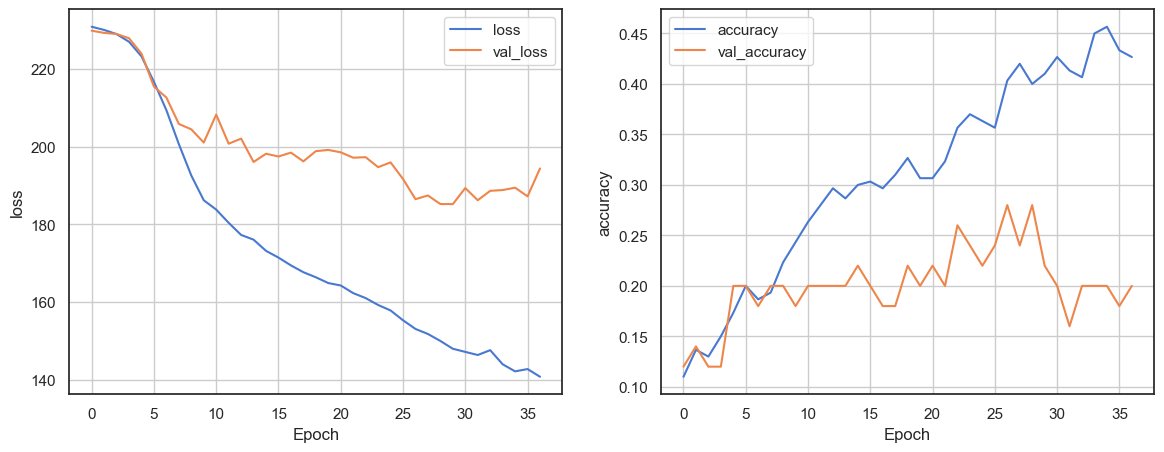

2/2 [==============================] - 0s 35ms/step - loss: 1.8149 - accuracy: 0.2800


2023-08-26 05:35:21.439801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype float
	 [[{{node Placeholder/_16}}]]
2023-08-26 05:35:21.440042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


{'loss': 1.81494140625, 'accuracy': 0.2800000011920929}

2/2 [==============================] - 0s 35ms/step


2023-08-26 05:35:21.648475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:21.648999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:21.649491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

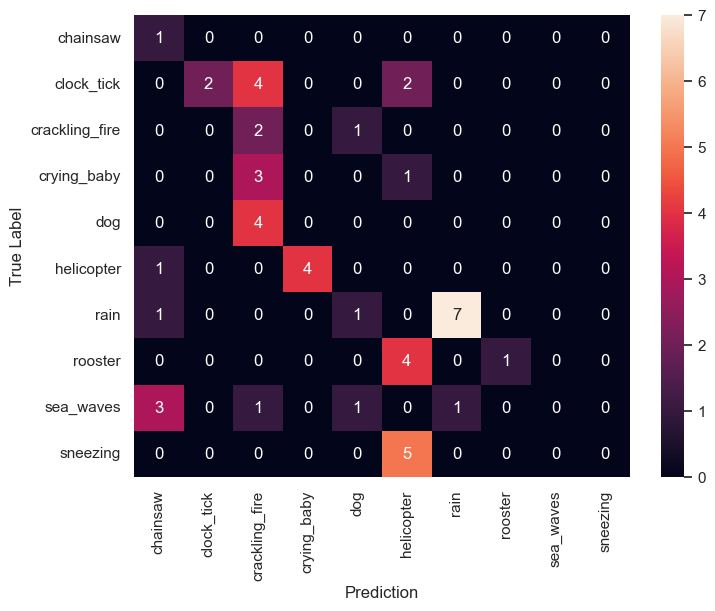

The most misclassified class is crackling_fire
Audio category: crackling_fire


The are more audio predicted as crackling_fire then actually is:
Audio category misclassified as crackling_fire: dog


In [ ]:
# We load the dictionary of the best parameters which are the MFCC ones with delta and delta_delta
with open(os.path.join(main_dir,'Models','best_params_RNN_raw_241.pickle'), 'rb') as handle:
    best_params = pickle.load(handle)

#refit only the best model
model = build_model(n_labels = n_labels, compile = False, **best_params)
learning_rate = best_params['learning_rate']
epochs =  50
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)


### 2.4.2 GRU - STFT Audio preprocessed - 10 classes

Preprocessing: STFT
Audio shape: (30, 501, 442)
Label shape: (30, 10)
Label: dog


2023-08-26 05:35:22.060284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]
2023-08-26 05:35:22.060499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 05:35:22.159776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

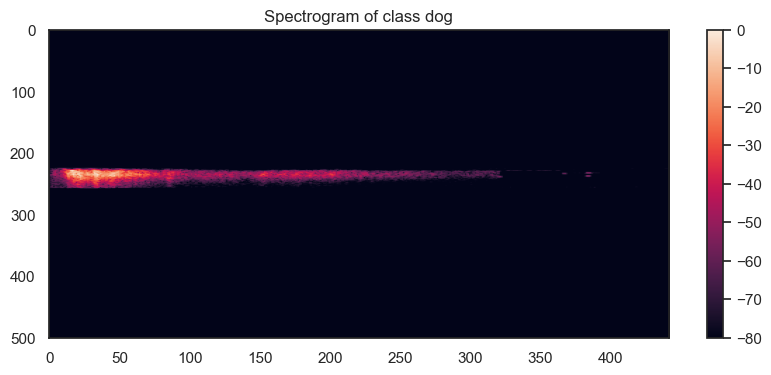

In [ ]:
batch_size = 30
preprocessing = 'STFT'
dataset, label = create_dataset_lite(df_ESC10,
                                     batch_size = batch_size,
                                     preprocessing= preprocessing,
                                     ndim = 2,
                                     transpose = True)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 1)

In [ ]:
def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = INPUT_DIM,
                 n_units = 8,
                 activation = 'tanh',
                 n_hidden_layers = 1,
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0,
                 compile = True):

        # Define Simple RNN  model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GRU(units = n_units, activation = activation, input_shape=INPUT_DIM, return_sequences = True if n_hidden_layers > 1 else False))
    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            model.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, input_shape=INPUT_DIM, return_sequences = True if i < n_hidden_layers - 1 else False))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()

    print(f'units of GRU {n_units}, lr {learning_rate}, activation {activation}, n_hidden_layers {n_hidden_layers}')

    return model


In [ ]:
epochs = 50
patience = 10
params = {'n_units':[8,16,32], 'activation':['tanh'], 'learning_rate':[1e-3], 'n_hidden_layers':[1,2,3]}
#params = {'n_units':[8,16], 'activation':['tanh'], 'learning_rate':[1e-3], 'n_hidden_layers':[1]}

K_fold = 4

model_cv, result, best_params = K_fold_training(dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 0, K=K_fold)


2023-08-26 05:35:22.313549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 05:35:22.313730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]


(400, 501, 442)
(400, 10)
units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:35:23.425280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:23.425709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:23.426103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.16
units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:35:32.992206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:32.992669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:32.993195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.06


2023-08-26 05:35:43.308573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:43.309003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:43.309395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:35:43.642794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:43.643278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:43.643753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.11


2023-08-26 05:35:52.958077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:52.958521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:52.958944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:35:53.723023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:35:53.723534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:35:53.724009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.11
units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:36:03.552622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:36:03.553037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:36:03.553431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.11
units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:36:16.393781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:36:16.394203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:36:16.394601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.02
units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:36:31.257481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:36:31.257909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:36:31.258318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.12
units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:36:44.227318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:36:44.227755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:36:44.228245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:36:56.361150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:36:56.361607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:36:56.362027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:36:56.701435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:36:56.701945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:36:56.702580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:37:17.083746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:37:17.084186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:37:17.084831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:37:17.433158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:37:17.433676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:37:17.434154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.02
units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:37:39.235579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:37:39.236014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:37:39.236426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.09
units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 05:37:58.619268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:37:58.619706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:37:58.620116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:38:12.419460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:38:12.419894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:38:12.420308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:38:12.655483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:38:12.655963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:38:12.656420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:38:43.626481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:38:43.626905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:38:43.627345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:38:43.885389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:38:43.885899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:38:43.886365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.02


2023-08-26 05:39:04.527029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:39:04.527845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:39:04.528707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:39:04.769649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:39:04.770223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:39:04.770715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:39:22.824994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:39:22.825417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:39:22.825817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:39:23.055602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:39:23.056088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:39:23.056640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08
units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:39:42.043402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:39:42.043946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:39:42.044520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:40:28.249000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:40:28.249429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:40:28.250042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:40:28.485395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:40:28.485893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:40:28.486345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:41:01.823647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:41:01.824074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:41:01.824509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:41:02.079626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:41:02.080133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:41:02.080717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.25
units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:42:16.986448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:42:16.986872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:42:16.987396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:42:54.493458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:42:54.493911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:42:54.494324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:42:54.740927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:42:54.741410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:42:54.741865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:43:27.476997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:43:27.477440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:43:27.477857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:43:27.717053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:43:27.717565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:43:27.718181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.02


2023-08-26 05:43:56.131872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:43:56.132320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:43:56.132772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:43:56.392725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:43:56.393222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:43:56.393721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.15


2023-08-26 05:44:53.814951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:44:53.815370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:44:53.815991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 05:44:54.049456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:44:54.050016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:44:54.050524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.16


2023-08-26 05:45:29.046664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:45:29.047104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:45:29.047640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:45:29.286593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:45:29.287088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:45:29.287557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:46:10.667715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:46:10.668163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:46:10.668573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:46:10.906324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:46:10.906820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:46:10.907292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.02


2023-08-26 05:46:43.523294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:46:43.523713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:46:43.524113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:46:43.757390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:46:43.757883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:46:43.758355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.15


2023-08-26 05:47:20.521342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:47:20.521774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:47:20.522181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:47:20.761936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:47:20.762419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:47:20.762889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.09


2023-08-26 05:47:46.187342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:47:46.187794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:47:46.188204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:47:46.431009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:47:46.431520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:47:46.432122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.22


2023-08-26 05:49:35.466628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:49:35.467041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:49:35.467574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:49:35.702255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:49:35.702745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:49:35.703197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:50:27.021330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:50:27.021772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:50:27.022410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:50:27.259850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:50:27.260351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:50:27.260866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.09


2023-08-26 05:51:07.514889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:51:07.515305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:51:07.515709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:51:07.763360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:51:07.763870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:51:07.764449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:51:48.517442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:51:48.517862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:51:48.518301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:51:48.758336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:51:48.758900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:51:48.759504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.49


2023-08-26 05:55:05.644327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:55:05.644777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:55:05.645182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:55:05.880848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:55:05.881366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:55:05.881841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.32


2023-08-26 05:58:22.506862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:58:22.507298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:58:22.507705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:58:22.771919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:58:22.772448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:58:22.772967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.08


2023-08-26 05:59:27.970689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:59:27.971118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:59:27.971522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 05:59:28.205063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 05:59:28.205553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 05:59:28.206194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.21


mean_accuracy
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.2750
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.1225
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.1175
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.1100
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.1025
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.0850
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.0825
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.0675
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.0650

In [ ]:
print("The best params are:", {key: value for key, value in best_params.items() if key != 'INPUT_DIM'})

# save the best_params in pickle
with open(os.path.join(main_dir,'Models','best_params_RNN_STFT_242.pickle'), 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

The best params are: {'activation': 'tanh', 'learning_rate': 0.001, 'n_hidden_layers': 3, 'n_units': 32}


In [ ]:
# refit only the best model
#best_params = {'activation': 'tanh', 'learning_rate': 0.001, 'n_hidden_layers': 3, 'n_units': 16}
seed = 42
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = 'STFT'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 2
                                                                      )


Found 400 files belonging to 10 classes.


Using 300 files for training.
Using 100 files for validation.


2023-08-26 16:10:24.103677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 16:10:24.103855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 16:10:25.723880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float
	 [[{{node Placehol

In [ ]:
# We load the dictionary of the best parameters which are the MFCC ones with delta and delta_delta
with open(os.path.join(main_dir,'Models','best_params_RNN_STFT_242.pickle'), 'rb') as handle:
    best_params = pickle.load(handle)

#build the model with best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
lr = best_params['learning_rate' ]
epochs = 50
patience = 10
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=lr),
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)


### 2.4.3 GRU - MEL Audio preprocessed - 10 classes

In [ ]:
batch_size = 30
preprocessing = 'MEL'
dataset, label = create_dataset_lite(df_ESC10,
                                     batch_size = batch_size,
                                     preprocessing= preprocessing,
                                     ndim = 2,
                                     transpose = True)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 0)

Preprocessing: MEL


2023-08-26 12:42:08.634074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 12:42:08.634264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]
2023-08-26 12:42:09.084763: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

In [ ]:
def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = INPUT_DIM,
                 n_units = 8,
                 activation = 'tanh',
                 n_hidden_layers = 1,
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0,
                 compile = True):

     # Define Simple RNN  model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GRU(units = n_units, activation = activation, input_shape=INPUT_DIM, return_sequences = True if n_hidden_layers > 1 else False))
    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            model.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, input_shape=INPUT_DIM, return_sequences = True if i < n_hidden_layers - 1 else False))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))

    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()

    print(f' units of GRU {n_units}, lr {learning_rate}, activation {activation}, n_hidden_layers {n_hidden_layers}')

    return model


In [ ]:
epochs = 50
patience = 10
params = {'n_units':[8,16,32], 'activation':['tanh'], 'learning_rate':[1e-3], 'n_hidden_layers':[1,2,3]}
#params = {'n_units':[8,12], 'activation':['tanh'], 'learning_rate':[1e-3], 'n_hidden_layers':[1]}

K_fold = 4

model_cv, result, best_params = K_fold_training(dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 0, K=K_fold)

2023-08-26 12:42:13.343001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 12:42:13.343375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]


(400, 501, 128)
(400, 10)


2023-08-26 12:42:18.078135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:42:18.081262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:42:18.083183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:42:18.495357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:42:18.495848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:42:18.496311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.11
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:42:35.233571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:42:35.235028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:42:35.235642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.07
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:42:48.019645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:42:48.020249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:42:48.020762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.2
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:42:56.969319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:42:56.970493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:42:56.970901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.18
 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:43:22.441777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:43:22.442316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:43:22.443115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.21
 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:43:58.157544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:43:58.158007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:43:58.158443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.27
 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:44:24.130139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:44:24.130609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:44:24.131301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.3
 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:44:58.900160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:44:58.901049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:44:58.901587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.16
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:45:14.997457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:45:14.997924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:45:14.998505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.46
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:45:57.139809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:45:57.140691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:45:57.141352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.35
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:46:20.701492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:46:20.701936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:46:20.702341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.2
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1


2023-08-26 12:46:37.275134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:46:37.275568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:46:37.275971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.1


2023-08-26 12:46:52.829895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:46:52.830398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:46:52.830986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:46:53.027728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2023-08-26 12:46:53.102519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:46:53.103113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

accuracy on test for this fold is 0.34


2023-08-26 12:48:00.087679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:48:00.088120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:48:00.088536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:48:00.293052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:48:00.297185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:48:00.297844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.34


2023-08-26 12:49:15.573257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:49:15.573683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:49:15.574117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:49:15.829278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:49:15.829795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:49:15.830281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.26


2023-08-26 12:50:03.128077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:50:03.128527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:50:03.128952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:50:03.404827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:50:03.405356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:50:03.405843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.38


2023-08-26 12:51:18.601508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:51:18.601963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:51:18.602392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:51:18.863087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:51:18.863602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:51:18.864163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.5


2023-08-26 12:52:49.068797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:52:49.070617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:52:49.071558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:52:49.304483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:52:49.305684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:52:49.306271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.4
 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:53:54.908128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:53:54.908568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:53:54.908989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.45


2023-08-26 12:55:00.878566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:55:00.879010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:55:00.879431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:55:01.132264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:55:01.132774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:55:01.133480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.47
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:56:16.891520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:56:16.891953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:56:16.892522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.59
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:57:28.647298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:57:28.647806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:57:28.648279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.6


2023-08-26 12:59:07.900873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:59:07.901308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 12:59:07.901722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 12:59:08.103198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2023-08-26 12:59:08.180934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 12:59:08.181552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

accuracy on test for this fold is 0.54
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2


2023-08-26 13:00:43.461108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:00:43.461529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:00:43.461938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.43


2023-08-26 13:01:53.691390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:01:53.691834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:01:53.692256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:01:53.948960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:01:53.949451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:01:53.949933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.28


2023-08-26 13:03:25.351663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:03:25.352182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:03:25.352638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:03:25.602167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:03:25.602694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:03:25.603328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.26


2023-08-26 13:04:29.050723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:04:29.051338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:04:29.051902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:04:29.293042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:04:29.293756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:04:29.294708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.42


2023-08-26 13:06:00.705508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:06:00.705945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:06:00.706361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:06:00.959044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:06:00.959571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:06:00.960059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.31


2023-08-26 13:07:31.552645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:07:31.553085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:07:31.553509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:07:31.811086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:07:31.811589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:07:31.812064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.52


2023-08-26 13:09:35.844240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:09:35.844671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:09:35.845102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:09:36.094759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:09:36.095392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:09:36.095884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.38


2023-08-26 13:10:34.013271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:10:34.013736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:10:34.014171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:10:34.294630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:10:34.295279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:10:34.295943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.61


2023-08-26 13:12:43.744978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:12:43.745447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:12:43.745865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 16, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:12:44.000922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:12:44.001461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:12:44.001953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.57


2023-08-26 13:14:51.872768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:14:51.873243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:14:51.873678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:14:52.159294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:14:52.161074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:14:52.161834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.55


2023-08-26 13:16:42.822394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:16:42.822876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:16:42.823350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:16:43.115286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:16:43.115799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:16:43.116277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.44


2023-08-26 13:18:23.453759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:18:23.454214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:18:23.454901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:18:23.727031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:18:23.727540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:18:23.728020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.57


2023-08-26 13:21:47.962742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:21:47.963176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:21:47.963587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 3


2023-08-26 13:21:48.219080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:21:48.219608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:21:48.220212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.58


mean_accuracy
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.5400
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.5350
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.5200
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.4550
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.3300
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.3175
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.2775
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.2350
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.1400

In [ ]:
print("The best params are:", {key: value for key, value in best_params.items() if key != 'INPUT_DIM'})

# save the best_params in pickle
with open(os.path.join(main_dir,'Models','best_params_RNN_MEL_243.pickle'), 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

The best params are: {'activation': 'tanh', 'learning_rate': 0.001, 'n_hidden_layers': 2, 'n_units': 32}


In [ ]:
#best_params = {'activation': 'tanh', 'learning_rate': 0.001, 'n_hidden_layers': 2, 'n_units': 32} #or n_units:64

# refit only the best model
seed = 42
tf.random.set_seed(seed)
path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = 'MEL'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 2,
                                                                      )

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


2023-08-26 13:24:51.731156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 13:24:51.731395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 13:24:57.706742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float
	 [[{{node Placehol

In [ ]:
# We load the dictionary of the best parameters which are the MFCC ones with delta and delta_delta
with open(os.path.join(main_dir,'Models','best_params_RNN_MEL_243.pickle'), 'rb') as handle:
    best_params = pickle.load(handle)

# build the model with best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
lr = best_params['learning_rate']
epochs = 50
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=lr)

model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],#,'CategoricalAccuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)

 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_196 (GRU)               (None, 501, 32)           15552     
                                                                 
 gru_197 (GRU)               (None, 64)                18816     
                                                                 
 dense_122 (Dense)           (None, 10)                650       
                                                                 
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-08-26 13:25:04.524144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:25:04.526629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:25:04.528173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

TypeError: in user code:

    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/layers/rnn/gru.py", line 642, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'gru_196' (type GRU).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'gru_196' (type GRU):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=True
      • initial_state=None


### 2.4.4 GRU - MFCC Audio preprocessed - 10 classes

Preprocessing: MFCC


2023-08-26 13:33:39.488545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]
2023-08-26 13:33:39.488770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]


Audio shape: (30, 501, 40)
Label shape: (30, 10)
Label: dog


2023-08-26 13:33:39.971597: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


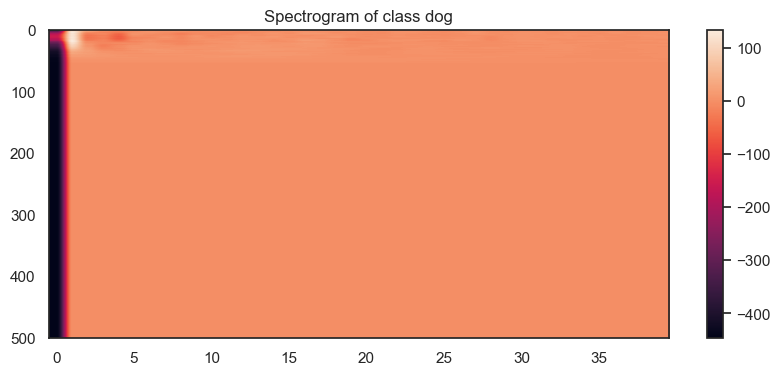

In [ ]:
batch_size = 30
preprocessing = 'MFCC'
delta = False
delta_delta = False
dataset, label = create_dataset_lite(df_ESC10,
                                     batch_size = batch_size,
                                     preprocessing= preprocessing,
                                     delta = delta,
                                     delta_delta = delta_delta,
                                     ndim = 2,
                                     transpose = True)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 1)

In [ ]:
def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = INPUT_DIM,
                 n_units = 8,
                 activation = 'tanh',
                 order = 2, # order of the delta and delta_delta coefficients
                 n_hidden_layers = 1,
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0,
                 compile = True):

    # Define Simple RNN  model
    model = tf.keras.Sequential()
    #eventually starts with a layer that computes the delta and delta_delta coefficients
    if order > 0:
        model.add(MFCCWithDeltaLayer(n_mfcc=40, order=order, input_shape=INPUT_DIM))
        model.add(tf.keras.layers.GRU(units = n_units, activation = activation, return_sequences = True if n_hidden_layers > 1 else False))
    elif order == 0:
        model.add(tf.keras.layers.GRU(units = n_units, activation = activation, input_shape=INPUT_DIM, return_sequences = True if n_hidden_layers > 1 else False))

    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            model.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, input_shape=INPUT_DIM, return_sequences = True if i < n_hidden_layers - 1 else False))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))

    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()

    print(f' units of GRU {n_units}, lr {learning_rate}, activation {activation}, n_hidden_layers {n_hidden_layers}, order {order}')

    return model


We split the grid search in two beacuse to use the GPU on colab the GRU cell must have tanh as activation function. Thus we tested ReLu locally and tanh on Google Colab Pro.

##### Activation ReLu

In [ ]:
epochs = 50
patience = 10
params = {'n_units':[8, 32], 'activation':['relu'], 'learning_rate':[1e-3], 'n_hidden_layers':[0, 1 ,2],'order':[0,1,2]}
#params = {'n_units':[8, 32], 'activation':['relu'], 'learning_rate':[1e-3], 'n_hidden_layers':[0],'order':[0]}

K_fold = 4

model_cv, result, best_params_relu = K_fold_training(dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 0, K=K_fold)


2023-08-26 13:33:58.588465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [400]
	 [[{{node Placeholder/_0}}]]
2023-08-26 13:33:58.588863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [400,10]
	 [[{{node Placeholder/_1}}]]


(400, 501, 40)
(400, 10)
 units of GRU 8, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.16
 units of GRU 8, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.16
 units of GRU 8, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.16
 units of GRU 8, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.2
 units of GRU 32, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.43
 units of GRU 32, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.42
 units of GRU 32, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.57
 units of GRU 32, lr 0.001, activation relu, n_hidden_layers 0, order 0
accuracy on test for this fold is 0.49
 units of GRU 8, lr 0.001, activation relu, n_hidden_layers 1, order 0
accuracy on test for 

/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sciker

mean_accuracy
{'activation': 'relu', 'learning_rate': 0.001, ...         0.6575
{'activation': 'relu', 'learning_rate': 0.001, ...         0.4825
{'activation': 'relu', 'learning_rate': 0.001, ...         0.4775
{'activation': 'relu', 'learning_rate': 0.001, ...         0.4225
{'activation': 'relu', 'learning_rate': 0.001, ...         0.1950
{'activation': 'relu', 'learning_rate': 0.001, ...         0.1700
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN
{'activation': 'relu', 'learning_rate': 0.001, ...            NaN

##### Activation Tanh

In [ ]:
epochs = 50
patience = 10
params = {'n_units':[8, 32], 'activation':['tanh'], 'learning_rate':[1e-3], 'n_hidden_layers':[0, 1 ,2],'order':[0,1,2]}
#params = {'n_units':[8, 32], 'activation':['tanh'], 'learning_rate':[1e-3], 'n_hidden_layers':[0],'order':[0]}

K_fold = 4

model_cv, result, best_params_tanh = K_fold_training(dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 0, K=K_fold)


(400, 501, 40)
(400, 10)
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:50:41.776115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:50:41.776583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:50:41.777159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.23
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:51:11.949983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:51:11.950494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:51:11.951117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.37
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:51:41.990193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:51:41.990692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:51:41.991292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.41
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:52:12.000357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:52:12.000859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:52:12.001315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.34
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:52:42.509768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:52:42.510192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:52:42.510802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.55
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:53:18.049334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:53:18.049832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:53:18.050288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.57
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:53:53.592725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:53:53.593204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:53:53.593665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.68
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 0, order 0


2023-08-26 13:54:29.080541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:54:29.081033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:54:29.081618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.57
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:55:04.532599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:55:04.533022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:55:04.533437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.35
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:55:34.577586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:55:34.578085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:55:34.578761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.18
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:56:04.573379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:56:04.573890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:56:04.574353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.35
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:56:34.669190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:56:34.669681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:56:34.670144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.22
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:57:05.191561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:57:05.191984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:57:05.192381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.6
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:57:40.764005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:57:40.764504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:57:40.764968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.63
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:58:16.218346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:58:16.218842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:58:16.219423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.69
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 1, order 0


2023-08-26 13:58:51.992921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:58:51.993384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:58:51.994077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.58
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 13:59:28.104324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 13:59:28.104755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 13:59:28.105292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.38
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:00:35.748533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:00:35.748948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:00:35.749356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.4
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:01:42.885780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:01:42.886211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:01:42.886762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.55
 units of GRU 8, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:02:51.018277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:02:51.018699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:02:51.019121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.53
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:03:58.625156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:03:58.625634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:03:58.626154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.63
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:05:27.477648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:05:27.478078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:05:27.478506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.61
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:06:56.121088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:06:56.121534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:06:56.122088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.66
 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2, order 0


2023-08-26 14:08:13.052005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:08:13.052418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:08:13.052994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

accuracy on test for this fold is 0.62


/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sciker

mean_accuracy
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.6300
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.6250
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.5925
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.4650
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.3375
{'activation': 'tanh', 'learning_rate': 0.001, ...         0.2750
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN
{'activation': 'tanh', 'learning_rate': 0.001, ...            NaN

##### Refit the best model only

In [ ]:
print("The best params are:", {key: value for key, value in best_params_tanh.items() if key != 'INPUT_DIM'})

# save the best_params in pickle
with open(os.path.join(main_dir,'Models','best_params_RNN_MFCC_244.pickle'), 'wb') as handle:
    pickle.dump(best_params_tanh, handle, protocol=pickle.HIGHEST_PROTOCOL)

The best params are: {'activation': 'tanh', 'learning_rate': 0.001, 'n_hidden_layers': 2, 'n_units': 32, 'order': 0}


In [ ]:
# refit only the best model
seed = 42
tf.random.set_seed(seed)
path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = 'MFCC'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      delta = False,
                                                                      delta_delta = False,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 2,
                                                                      )


Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


2023-08-26 14:09:33.103923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-08-26 14:09:33.104097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-08-26 14:09:36.802734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [

In [ ]:
# We load the dictionary of the best parameters which are the MFCC ones with delta and delta_delta
with open(os.path.join(main_dir,'Models','best_params_RNN_MFCC_244.pickle'), 'rb') as handle:
    best_params = pickle.load(handle)

model = build_model(n_labels = n_labels, compile = False, **best_params)
epochs = 50
patience = 10
lr = best_params['learning_rate']
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=lr)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],#,'CategoricalAccuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)




 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2, order 0
Model: "sequential_267"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_262 (GRU)               (None, 501, 32)           7104      
                                                                 
 gru_263 (GRU)               (None, 64)                18816     
                                                                 
 dense_171 (Dense)           (None, 10)                650       
                                                                 
Total params: 26,570
Trainable params: 26,570
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-08-26 14:09:40.216315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 14:09:40.216803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 14:09:40.217226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

TypeError: in user code:

    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/layers/rnn/gru.py", line 642, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'gru_262' (type GRU).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'gru_262' (type GRU):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=True
      • initial_state=None


### 2.4.5 GRU with STFT audio preprocessed - 50 classes

In [ ]:
seed = 42
tf.random.set_seed(seed)
path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-50-depth')

#best_params = {'activation': 'tanh', 'learning_rate': 0.001, 'n_hidden_layers': 3, 'n_units': 16}

#create the dataset
batch_size = 30
preprocessing = 'STFT' #the best preprocessing by grid search

#as always for the ESC50 it is better to save the dataset for the future calls
save_train_file = os.path.join(main_dir,'Saved_Datasets','ESC50_STFT_train')
save_val_file = os.path.join(main_dir,'Saved_Datasets','ESC50_STFT_val')
save_test_file =  os.path.join(main_dir,'Saved_Datasets','ESC50_STFT_test')
save_labels_file = os.path.join(main_dir,'Saved_Datasets','ESC50_STFT_labels')
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                    batch_size = batch_size,  # batch size
                                                                    preprocessing = preprocessing,
                                                                    verbose = 0,
                                                                    show_example_batch = True,
                                                                    ndim = 2,
                                                                    save_train = save_train_file,
                                                                    save_test = save_test_file,
                                                                    save_val = save_val_file,
                                                                    save_labels = save_labels_file
                                                                    )

Found 2000 files belonging to 50 classes.
Using 1500 files for training.
Using 500 files for validation.


2023-08-26 14:46:17.121292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]
	 [[{{node Placeholder/_4}}]]
2023-08-26 14:46:17.121536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]
	 [[{{node Placeholder/_4}}]]


dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


2023-08-26 14:46:24.364934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]
	 [[{{node Placeholder/_4}}]]
2023-08-26 14:46:24.365257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float
	 [[{{node Placeholder/_21}}]]


dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


2023-08-26 14:46:35.201934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [500]
	 [[{{node Placeholder/_4}}]]
2023-08-26 14:46:35.202245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [500]
	 [[{{node Placeholder/_0}}]]


dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


2023-08-26 14:46:36.486667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype float
	 [[{{node Placeholder/_19}}]]
2023-08-26 14:46:36.486954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [500]
	 [[{{node Placeholder/_4}}]]
2023-08-26 14:46:37.922666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]
	 [[{{node Placeh

We use the same build function used in 2.4.2 (with STFT prepocessing)

In [ ]:
# We load the dictionary of the best parameters which are the MFCC ones with delta and delta_delta
with open(os.path.join(main_dir,'Models','best_params_RNN_STFT_242.pickle'), 'rb') as handle:
    best_params = pickle.load(handle)

def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = INPUT_DIM,
                 n_units = 8,
                 activation = 'tanh',
                 n_hidden_layers = 1,
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0,
                 compile = True):

        # Define Simple RNN  model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GRU(units = n_units, activation = activation, input_shape=INPUT_DIM, return_sequences = True if n_hidden_layers > 1 else False))
    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            model.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, input_shape=INPUT_DIM, return_sequences = True if i < n_hidden_layers - 1 else False))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()

    print(f'units of GRU {n_units}, lr {learning_rate}, activation {activation}, n_hidden_layers {n_hidden_layers}')

    return model

model = build_model(n_labels = n_labels, compile = False, **best_params)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 501, 16)           22080     
                                                                 
 gru_1 (GRU)                 (None, 501, 32)           4800      
                                                                 
 gru_2 (GRU)                 (None, 48)                11808     
                                                                 
 dense_2 (Dense)             (None, 50)                2450      
                                                                 
Total params: 41,138
Trainable params: 41,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 83s 1s/step - loss: 3.9227 - accuracy: 0.0247 - val_loss: 3.8992 - val_accuracy: 0.0280
Epoch 2/100
50/50 [======================

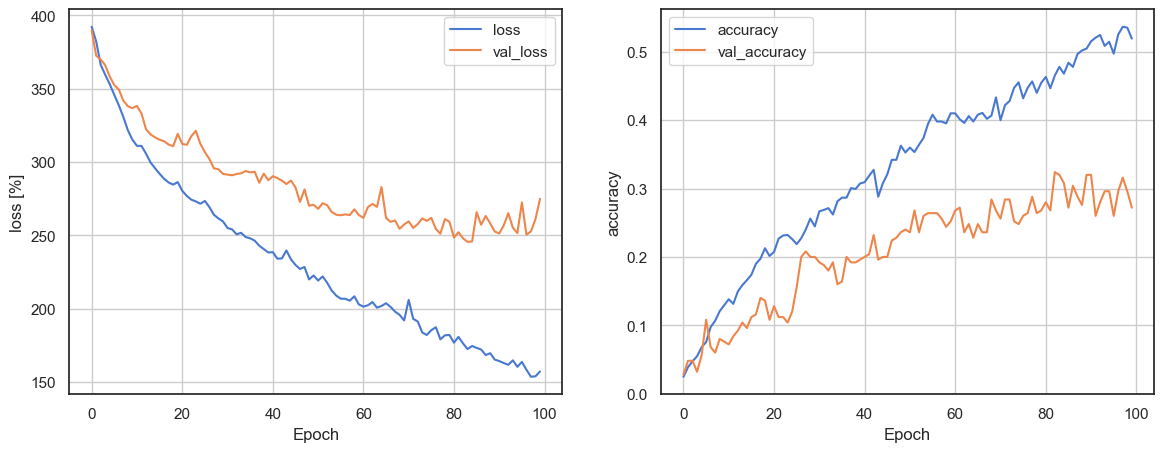

9/9 [==============================] - 3s 275ms/step - loss: 2.6217 - accuracy: 0.2920


{'loss': 2.6217219829559326, 'accuracy': 0.2919999957084656}

9/9 [==============================] - 5s 240ms/step


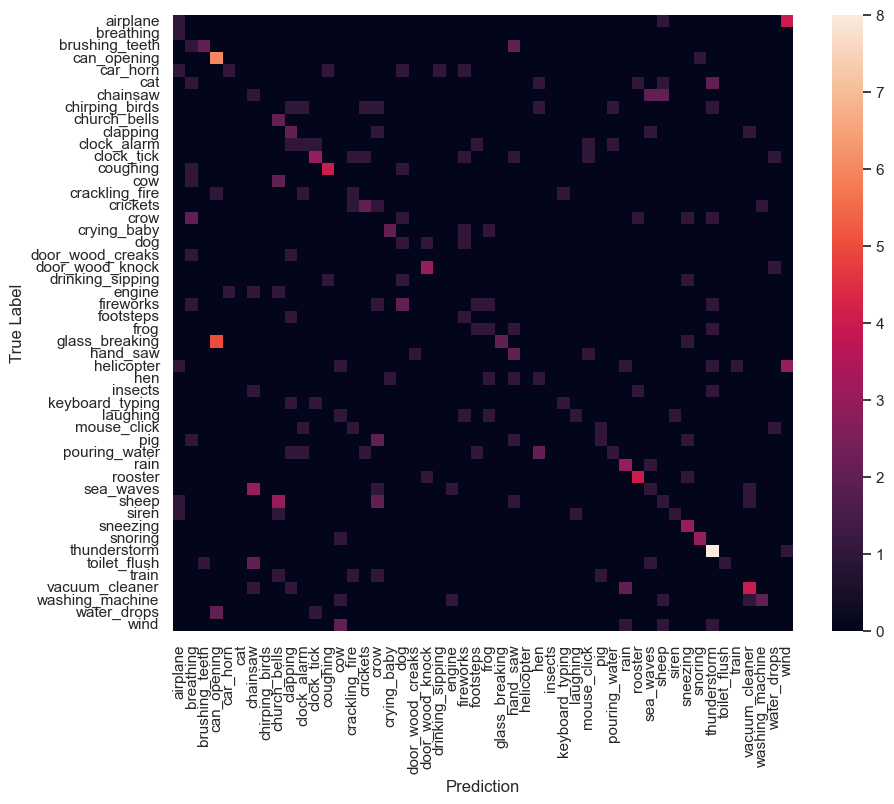

The most misclassified class is breathing
Audio category: breathing


The are more audio predicted as breathing then actually is:
Audio category misclassified as breathing: crow


In [ ]:
#Train the model
epochs = 50
patience = 10
lr = best_params['learning_rate']
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=lr)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC50, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)


### 2.4.6 GRU with MFCC audio preprocessed - 50 classes

In [ ]:
seed = 42
tf.random.set_seed(seed)
path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-50-depth')

#create the dataset
batch_size = 30
preprocessing = 'MFCC' #the best preprocessing by grid search
delta = False
delta_delta = False

#as always for the ESC50 it is better to save the dataset for the future calls
save_train_file = os.path.join(main_dir,'Saved_Datasets','ESC50_MFCC_train')
save_val_file = os.path.join(main_dir,'Saved_Datasets','ESC50_MFCC_val')
save_test_file =  os.path.join(main_dir,'Saved_Datasets','ESC50_MFCC_test')
save_labels_file = os.path.join(main_dir,'Saved_Datasets','ESC50_MFCC_labels')
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                    batch_size = batch_size,  # batch size
                                                                    preprocessing = preprocessing,
                                                                    verbose = 0,
                                                                    show_example_batch = True,
                                                                    ndim = 2,
                                                                    delta = delta,
                                                                    delta_delta = delta_delta,
                                                                    save_train = save_train_file,
                                                                    save_test = save_test_file,
                                                                    save_val = save_val_file,
                                                                    save_labels = save_labels_file
                                                                    )


We use the same build function used in 2.4.4 (with MFCC prepocessing)

In [ ]:
# We load the dictionary of the best parameters which are the MFCC ones with delta and delta_delta
with open(os.path.join(main_dir,'Models','best_params_RNN_MFCC_244.pickle'), 'rb') as handle:
    best_params = pickle.load(handle)


def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = INPUT_DIM,
                 n_units = 8,
                 activation = 'tanh',
                 order = 2, # order of the delta and delta_delta coefficients
                 n_hidden_layers = 1,
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0,
                 compile = True):

    # Define Simple RNN  model
    model = tf.keras.Sequential()
    #eventually starts with a layer that computes the delta and delta_delta coefficients
    if order > 0:
        model.add(MFCCWithDeltaLayer(n_mfcc=40, order=order, input_shape=INPUT_DIM))
        model.add(tf.keras.layers.GRU(units = n_units, activation = activation, return_sequences = True if n_hidden_layers > 1 else False))
    elif order == 0:
        model.add(tf.keras.layers.GRU(units = n_units, activation = activation, input_shape=INPUT_DIM, return_sequences = True if n_hidden_layers > 1 else False))
    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            model.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, input_shape=INPUT_DIM, return_sequences = True if i < n_hidden_layers - 1 else False))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))

    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()

    print(f' units of GRU {n_units}, lr {learning_rate}, activation {activation}, n_hidden_layers {n_hidden_layers}, order {order}')

    return model

model = build_model(n_labels = n_labels, compile = False, **best_params)


 units of GRU 32, lr 0.001, activation tanh, n_hidden_layers 2, order 0


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 501, 32)           7104      
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
Total params: 29,170
Trainable params: 29,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 42s 563ms/step - loss: 3.8859 - accuracy: 0.0193 - val_loss: 3.8095 - val_accuracy: 0.0600
Epoch 2/100
50/50 [==============================] - 25s 492ms/step - loss: 3.6602 - accuracy: 0.0347 - val_loss: 3.6327 - val_accuracy: 0.0440
Epoch 3/100
50/50 [=======

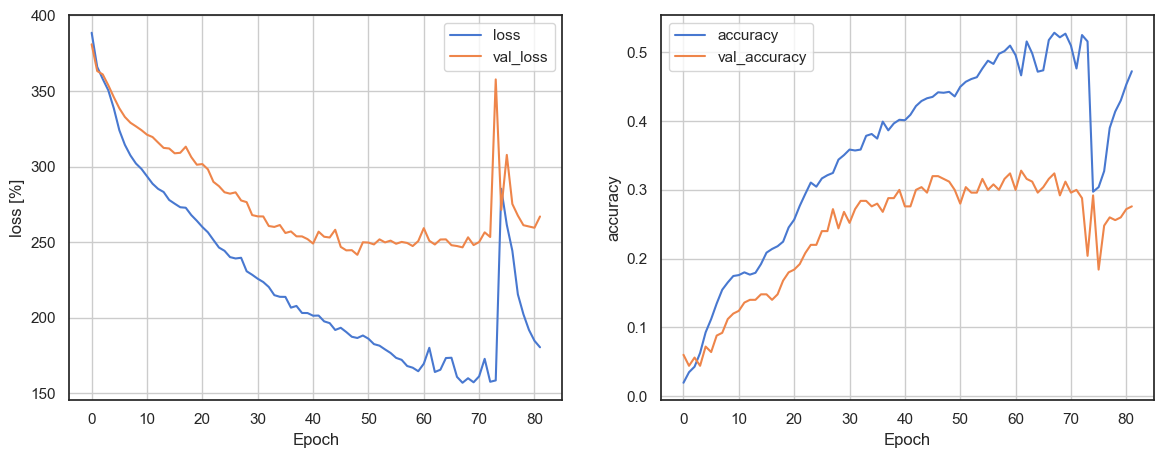

9/9 [==============================] - 1s 127ms/step - loss: 2.7118 - accuracy: 0.2920


{'loss': 2.7117602825164795, 'accuracy': 0.2919999957084656}

9/9 [==============================] - 3s 121ms/step


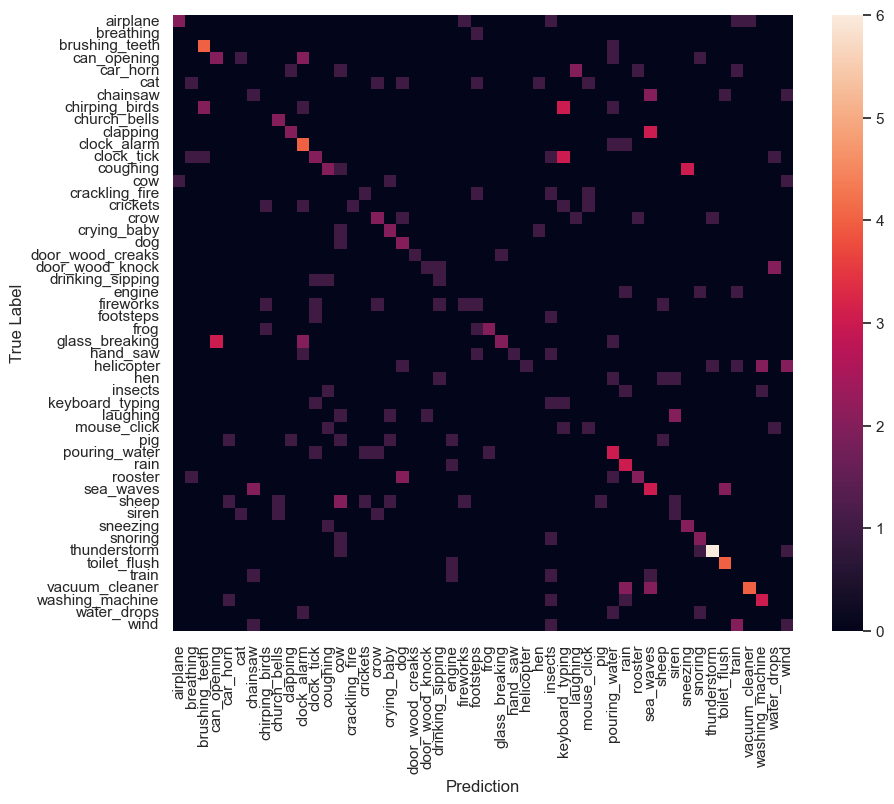

The most misclassified class is cow
Audio category: cow


The are more audio predicted as cow then actually is:
Audio category misclassified as cow: sheep


In [ ]:
lr = best_params['learning_rate']
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=lr)
#train the model
epochs = 50
patience = 10
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC50, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],#,'CategoricalAccuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)